#**CHAPTER 8. ORDER FLOW MECHANISM**
---

##0.REFERENCE

##1.CONTEXT

**A. Introduction — Strategy 8: Order Flow Mechanism (Synthetic, Deterministic, Auditable)**

Order flow is the closest thing market microstructure has to a “primitive.” Long before a return is recorded, before a factor is estimated, and before a risk model assigns exposures, the market is already negotiating: who wants immediacy, who is willing to wait, and what inventory must be warehoused to make the trade happen. In modern electronic markets, that negotiation is mediated by a limit order book (or dealer protocols that emulate it), and the object that reveals the negotiation in real time is not price, but **signed trading pressure**. The central economic claim behind an order-flow laboratory is therefore structural rather than predictive: price formation is not an abstract clearing price; it is an **allocation of scarce liquidity** under constraints. The relevant state variables are the ones that govern this allocation—depth, spreads, inventory tolerance, and the persistence of imbalances.

This notebook studies a specific mechanism: **order flow imbalance (OFI)** as a microstructure state variable, and how OFI can translate into short-horizon price pressure when liquidity provision is costly. The key educational point is that OFI is not a mystical alpha signal. It is an accounting identity with economic meaning. If a sequence of aggressive buys consumes offers faster than new offers appear, the book is mechanically pushed upward unless liquidity providers step in. Their willingness to step in depends on compensation (spreads), risk limits (inventory), and volatility (inventory risk). The notebook builds an internally consistent synthetic market where OFI is persistent, where depth varies by regime, and where spreads and execution costs respond to market stress. This makes the strategy’s “edge,” such as it is in the laboratory, a direct artifact of microstructure causality: imbalance meets constrained liquidity.

The economic context relevant to order flow is the **market for immediacy**. Participants demand immediacy for different reasons: portfolio rebalancing, hedging, liquidation, forced margin actions, or informational trading. Liquidity suppliers—market makers, high-frequency firms, and risk-warehousing dealers—provide immediacy at a price. That price appears as the bid–ask spread, but in practice the true cost includes slippage, transient impact, and nonlinear impact as trade size approaches depth. These costs are not “frictional details.” They are the microeconomic mechanism through which supply meets demand. In stressed regimes, depth thins, spreads widen, and the same imbalance produces larger price moves because the same quantity of immediacy consumes a larger fraction of available liquidity. Any realistic study of order flow must therefore embed execution realism: you cannot ask whether an imbalance signal “works” without simultaneously asking whether the trades required to exploit it are feasible at scale.

This notebook demonstrates a full institutional research lifecycle for an OFI mechanism, but it does so as a **laboratory** rather than a trading claim. The environment is synthetic by construction: there is no external data, no web calls, no APIs, and no hidden datasets. That constraint is a feature, not a limitation. It forces explicit assumptions, which is precisely what mechanism-first research requires. The market is generated as a multi-asset system with multiple regimes—calm, trending, crisis, and choppy—each with its own structural parameters: market volatility, idiosyncratic volatility, correlation, depth, spreads, and the mapping from OFI to next-day returns. The regime design is not intended to mimic a particular venue or product; it is designed to provide controlled variation so that a researcher can isolate causal channels: What changes when correlation compresses? What changes when liquidity collapses? What changes when OFI loses predictive content or flips sign?

The mechanism-first stance also changes how we interpret “curves” and “surfaces.” In classical factor research, surfaces often mean efficient frontiers, risk–return trade-offs, or exposure maps. Here, the most important surfaces are **execution surfaces**: how cost scales with turnover, depth, spreads, and participation. Another central surface is a **regime-dependent response surface**: the relationship between an OFI z-score and subsequent returns as liquidity changes. Because the notebook is cross-sectional, it also builds dispersion surfaces: how cross-sectional signal dispersion evolves through time, and how that dispersion interacts with tradability filters. These surfaces are not marketing artifacts; they are diagnostic instruments. They show how a strategy’s feasibility is bounded by market microeconomics.

The notebook’s agentic structure is intentionally transparent. “Agentic” in this series does not mean black-box autonomy; it means the notebook is designed as a closed-loop system where a policy interacts with an environment under constraints, generating artifacts that support disciplined iteration. The agent here is a bounded policy: it observes a state derived from OFI and microstructure proxies, constructs a long/short book via rank-based selection, and then executes toward target weights subject to participation constraints and transaction cost models. The environment is the synthetic market generator plus the execution layer. This architecture allows a researcher to run interventions—stress tests, parameter sweeps, Monte Carlo perturbations—without changing the philosophy of the experiment. The point is not to optimize the policy; it is to understand how the mechanism behaves when the environment is perturbed.

Execution realism is not appended after the fact. It is embedded in the trading engine. Each rebalance is governed by a participation constraint that limits trading toward the target portfolio in proportion to depth. This creates a meaningful distinction between desired exposure and feasible exposure. Costs include half-spread and a convex impact term that scales with the trade fraction of depth. These modeling choices are deliberate: they express a structural truth about microstructure—impact is nonlinear, and it becomes punitive when size approaches available liquidity. The notebook also monitors turnover and drawdown duration, because microstructure strategies can fail not only by losing money but by forcing excessive churn that becomes unrecoverable under costs.

A critical educational theme is the separation between **signal** and **strategy**. The primary signal is a rolling z-score of OFI. But the strategy is the combination of signal, filters, portfolio construction, risk controls, and execution. The notebook enforces tradability gates (depth floor, spread cap, volatility guard). It constructs a dollar-neutral portfolio to reduce dependence on the market factor, but it still estimates and reports beta to a synthetic market return, explicitly decomposing realized returns into beta-attributed and residual components. This makes a crucial point: in microstructure strategies, “alpha” can accidentally be disguised beta or liquidity risk unless the research process forces the decomposition.

Governance is a first-class citizen. Each run produces a structured set of artifacts: run manifest, prompts log, risk log, metrics, diagnostics, equity curve, positions, stress results, parameter sensitivity, Monte Carlo envelope, fragility analysis, model risk score, governance maturity, deployment status, execution audit, reproducibility report, hash registry, audit index, and a final zip bundle. Every JSON artifact contains an explicit “Not verified” status, and facts are separated from assumptions and open items. The tamper-evident layer hashes every artifact and computes a master bundle hash. This is not bureaucratic overhead; it is the minimum infrastructure needed for internal reproducibility, committee review, and litigation-grade defensibility. A mechanism-first lab is only useful if another researcher can replicate the same outputs and understand what assumptions were embedded.

Finally, the notebook avoids predictive framing by design. It does not claim that OFI “predicts” returns in the real world. It claims that OFI is a mechanism that can generate short-horizon price pressure in a stylized market with constrained liquidity provision, and it shows how that pressure can be amplified or eliminated depending on regime structure, execution constraints, and the stability of the OFI-to-return mapping. The correct learning objective is professional intuition: to understand when an imbalance mechanism is structurally plausible, when it is likely to be crowded out by costs, and how fragile it becomes when its causal channel is attacked directly. That is the spirit of this laboratory: a disciplined microstructure experiment, not a performance narrative.


##2.LIBRARIES AND ENVIRONMENT

**Order Flow Mechanism (Synthetic, Deterministic, Auditable, Regulator-Ready)**

**Objective**
Build an institutional-grade research laboratory for an **order-flow imbalance** strategy with **execution realism**, **multi-regime microstructure**, **stress testing**, **parameter sensitivity**, **Monte Carlo robustness**, and a **tamper-evident audit bundle**.

**Synthetic & Governance Disclaimer**
- **Synthetic data only** (no external data, no web calls, no APIs).
- **Deterministic** under fixed CONFIG seed.
- Outputs are **Not verified** and **not investment advice**. This lab **does not claim real-world profitability**.

**10 Trade-Logic Elements (implemented in code)**
1) **Universe definition**: N synthetic liquid instruments (cross-section), with market factor + idiosyncratic microstructure.
2) **Primary signal**: Rolling **Order Flow Imbalance (OFI)** z-score per asset (microstructure-driven).
3) **Secondary filters**: Liquidity / depth floor, spread cap, volatility guard; optional regime-aware participation scaling.
4) **Entry rule**: Each day, **long top quantile** OFI z-scores; **short bottom quantile** (dollar-neutral).
5) **Exit rule**: Daily rebalance with finite participation; positions decay if liquidity/vol guards fail.
6) **Position direction**: Long/Short, **dollar-neutral**, bounded gross exposure.
7) **Holding horizon**: 1-day predictive horizon with controlled turnover + impact model.
8) **Portfolio construction**: Rank-weighted within long/short books; exposure scaling to target volatility; HHI monitored.
9) **Risk controls**: Max gross, max position weight, liquidity/depth constraints, drawdown stop trigger for de-risking.
10) **Governance gates**: Determinism certification, artifact hashing, model risk tiering, deployment classification, audit bundle.


In [1]:
# CELL 2 — Governance Setup (Imports, Helpers, CONFIG, Deterministic Seed, Root Artifacts)

import os, sys, json, math, random, statistics, hashlib, platform, zipfile, datetime
import matplotlib.pyplot as plt

# -----------------------------
# Deterministic CONFIG
# -----------------------------
CONFIG = {
    "strategy_name": "Strategy 8 — Order Flow Mechanism",
    "seed": 803008,                      # fixed deterministic seed
    "n_assets": 24,
    "n_days": 1200,
    "rebalance_every": 1,
    "signal_lookback": 20,
    "ic_lookback": 60,
    "vol_lookback": 60,
    "beta_lookback": 120,
    "long_quantile": 0.25,
    "short_quantile": 0.25,
    "target_daily_vol": 0.008,          # portfolio target vol (synthetic)
    "max_gross": 1.8,
    "max_pos_weight": 0.15,
    "participation_rate": 0.12,         # participation as fraction of depth
    "half_spread_bps_base": 3.0,        # base half-spread in bps (regime-modulated)
    "impact_k": 0.08,                   # nonlinear impact coefficient
    "impact_exp": 1.25,                 # convexity of impact
    "depth_floor": 0.35,                # minimum depth (relative scale)
    "spread_cap_bps": 20.0,             # cap for tradability
    "vol_cap": 0.05,                    # daily vol cap for tradability (synthetic)
    "drawdown_stop": 0.18,              # de-risk if DD breaches
    "de_risk_gross": 0.6,               # gross exposure when drawdown-stop triggers
    "timestamp_utc": datetime.datetime.now(datetime.timezone.utc).isoformat()
}

# -----------------------------
# Directory layout
# -----------------------------
ROOT = os.getcwd()
DELIV = os.path.join(ROOT, "deliverables")
os.makedirs(DELIV, exist_ok=True)

ROOT_FILES = ["run_manifest.json", "prompts_log.jsonl", "risk_log.json"]
DELIV_FILES = [
    "metrics_summary.json",
    "diagnostics.json",
    "equity_curve.json",
    "positions.json",
    "stress_test_results.json",
    "parameter_sensitivity.json",
    "monte_carlo_envelope.json",
    "fragility_analysis.json",
    "model_risk_score.json",
    "governance_maturity.json",
    "deployment_status.json",
    "signal_matrix.json",
    "execution_audit.json",
    "reproducibility_report.json",
    "artifact_hash_registry.json",
    "audit_index.json",
    "review_checklist.json"
]

# -----------------------------
# Governance JSON schema helper
# -----------------------------
def governed_payload(facts=None, assumptions=None, open_items=None, analysis=None, outputs=None):
    return {
        "verification_status": "Not verified",
        "facts_provided": facts if isinstance(facts, dict) else {},
        "assumptions": assumptions if isinstance(assumptions, dict) else {},
        "open_items": open_items if isinstance(open_items, list) else [],
        "analysis": analysis if isinstance(analysis, dict) else {},
        "outputs": outputs if isinstance(outputs, dict) else {}
    }

def write_json(path, payload):
    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, sort_keys=True)
    os.replace(tmp, path)

def append_jsonl(path, record):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(record, sort_keys=True) + "\n")

def sha256_bytes(b):
    h = hashlib.sha256()
    h.update(b)
    return h.hexdigest()

def sha256_file(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            chunk = f.read(1024 * 1024)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def stable_hash_dict(d):
    return sha256_bytes(json.dumps(d, sort_keys=True).encode("utf-8"))

def now_utc_iso():
    return datetime.datetime.now(datetime.timezone.utc).isoformat()

# -----------------------------
# Deterministic seed initialization
# -----------------------------
random.seed(CONFIG["seed"])

# -----------------------------
# Root governance artifacts
# -----------------------------
env_fingerprint = {
    "python": sys.version,
    "platform": platform.platform(),
    "executable": sys.executable,
    "cwd": ROOT
}

run_manifest = governed_payload(
    facts={
        "strategy": CONFIG["strategy_name"],
        "timestamp_utc": CONFIG["timestamp_utc"],
        "deterministic_seed": CONFIG["seed"],
        "data_policy": "Synthetic-only, no external calls",
        "constraints": "No pandas, no seaborn, no sklearn, no external APIs/web"
    },
    assumptions={
        "synthetic_market": "Regime-driven microstructure with order-flow impact channel",
        "execution": "Spread + convex impact cost vs depth",
        "risk": "Vol targeting + drawdown de-risk gate"
    },
    open_items=[
        "Independent replication required",
        "Human model risk review required before any real-world consideration",
        "Calibration to real microstructure is explicitly out of scope"
    ],
    analysis={
        "config_hash": stable_hash_dict(CONFIG),
        "env_fingerprint": env_fingerprint
    },
    outputs={}
)

write_json(os.path.join(ROOT, "run_manifest.json"), run_manifest)

prompt_record = {
    "timestamp_utc": now_utc_iso(),
    "run_id": stable_hash_dict({"seed": CONFIG["seed"], "ts": CONFIG["timestamp_utc"]})[:16],
    "strategy": CONFIG["strategy_name"],
    "config_hash": run_manifest["analysis"]["config_hash"],
    "note": "Governed synthetic order-flow laboratory; user prompt logged (redaction: none provided beyond generic spec)."
}
append_jsonl(os.path.join(ROOT, "prompts_log.jsonl"), prompt_record)

risk_log = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={
        "capability_risk": "Sophisticated backtest can be misused as performance claim; outputs remain Not verified.",
        "model_risk": "Synthetic assumptions may not transfer; microstructure approximations are stylized."
    },
    open_items=[
        "Define committee-approved usage policy for any downstream reuse",
        "Add independent code review sign-off before distribution"
    ],
    analysis={
        "minimum_controls": [
            "Deterministic seed + config hash",
            "Artifact hashing + tamper-evident bundle",
            "Stress tests + robustness envelope",
            "Explicit 'Not verified' status"
        ]
    },
    outputs={}
)
write_json(os.path.join(ROOT, "risk_log.json"), risk_log)

# Prepare empty governed deliverables (ensures presence every run)
for fn in DELIV_FILES:
    write_json(os.path.join(DELIV, fn), governed_payload())


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW

**Cell 3 — Synthetic Market Generator (Regimes, Microstructure, and OFI as a State Variable)**

Cell 3 constructs the environment in which the order flow mechanism can be studied as a causal object rather than a descriptive correlation. The purpose is to generate a synthetic multi-asset market with explicitly defined regime structure and microstructure variables—depth and spreads—so that order flow imbalance (OFI) has a coherent economic interpretation. Instead of importing historical prices, the cell specifies what “the market” means in this laboratory: a set of assets with market-factor exposure, idiosyncratic shocks, cross-asset correlation that varies by regime, and a microstructure layer that governs the feasibility and cost of execution.

The market mechanism being modeled is price formation under constrained liquidity provision. OFI is generated as an autoregressive process that captures persistence in aggressive trading pressure, while depth and spreads vary by regime to represent changes in liquidity supply and the price of immediacy. Crucially, the cell introduces a controlled mapping from OFI to next-day returns that depends on liquidity conditions. That mapping is not meant to represent a universal empirical truth; it is the experimental lever that allows the notebook to test the consequences of a microstructural hypothesis: imbalances can transmit to prices more strongly when depth is scarce and spreads widen.

From an environment logic perspective, this cell defines the regime schedule deterministically, ensuring reproducibility and enabling targeted stress injections later. Each regime comes with parameter bundles—volatility levels, correlation, base spread, base depth, OFI persistence, and OFI predictive coefficient. This makes regimes not merely labels, but structural states that alter the geometry of the market. In calm regimes, liquidity provision is abundant; in crisis, it is scarce and costly. Because the strategy is cross-sectional, the cell also builds stable cross-asset heterogeneity (betas and idiosyncratic scales), which ensures that dispersion exists and that portfolio construction is meaningful.

The agentic flow begins here: without a consistent environment, the agent’s behavior is uninterpretable. By explicitly generating depth and spread series, Cell 3 also prepares the execution constraints that later determine whether the agent can actually move to desired exposures. The learning objective is to internalize that a microstructure signal cannot be separated from the state variables that determine liquidity. OFI, depth, and spreads form a triad: pressure, capacity, and price of immediacy. The cell’s design ensures that when later cells report performance or fragility, those outcomes can be traced back to identifiable structural assumptions rather than hidden data quirks.




###3.2.CODE AND IMPLEMENTATION

In [6]:
# CELL 3 — Synthetic Market Generator (>=4 regimes; microstructure + order flow; manifest update)

def clamp(x, lo, hi):
    return lo if x < lo else hi if x > hi else x

def mean(xs):
    return sum(xs)/len(xs) if xs else 0.0

def stdev(xs):
    if len(xs) < 2:
        return 0.0
    return statistics.pstdev(xs)

def corr(xs, ys):
    n = min(len(xs), len(ys))
    if n < 2:
        return 0.0
    x = xs[:n]
    y = ys[:n]
    mx = mean(x); my = mean(y)
    vx = sum((xi-mx)**2 for xi in x)
    vy = sum((yi-my)**2 for yi in y)
    if vx <= 0.0 or vy <= 0.0:
        return 0.0
    cov = sum((x[i]-mx)*(y[i]-my) for i in range(n))
    return cov / math.sqrt(vx*vy)

def regime_schedule(n_days):
    # Four regimes with deterministic blocks + small deterministic “kinks”
    # 0 Calm, 1 Trend, 2 Crisis, 3 Chop
    blocks = []
    pattern = [
        (0, 260),
        (1, 240),
        (3, 220),
        (2, 160),
        (0, 160),
        (1, 160)
    ]
    s = 0
    for r, L in pattern:
        for _ in range(L):
            if s >= n_days:
                break
            blocks.append(r)
            s += 1
        if s >= n_days:
            break
    # pad deterministically
    while len(blocks) < n_days:
        blocks.append(0 if (len(blocks)//50) % 2 == 0 else 3)
    return blocks[:n_days]

REGIMES = {
    0: {"name": "CALM",  "mkt_vol": 0.008, "idio_vol": 0.012, "corr": 0.25, "spread_bps": 3.0,  "depth": 1.00, "ofi_ar": 0.35, "ofi_pred": 0.06},
    1: {"name": "TREND", "mkt_vol": 0.010, "idio_vol": 0.014, "corr": 0.35, "spread_bps": 4.0,  "depth": 0.85, "ofi_ar": 0.45, "ofi_pred": 0.05},
    2: {"name": "CRISIS","mkt_vol": 0.030, "idio_vol": 0.040, "corr": 0.75, "spread_bps": 14.0, "depth": 0.40, "ofi_ar": 0.20, "ofi_pred": 0.02},
    3: {"name": "CHOP",  "mkt_vol": 0.014, "idio_vol": 0.018, "corr": 0.15, "spread_bps": 6.0,  "depth": 0.75, "ofi_ar": 0.55, "ofi_pred": 0.03}
}

def generate_market(config, regimes_def, shock_overrides=None):
    """
    Returns dict with:
      - regimes[t] in {0,1,2,3}
      - mkt_ret[t]
      - ret[t][i]
      - price[t][i]
      - ofi[t][i]
      - depth[t][i]
      - spread_bps[t][i]
      - true_ofi_pred_coeff[t] (regime-level coefficient used)
    shock_overrides: optional callable(regime_id, t)-> dict overrides
    """
    nA = config["n_assets"]
    nT = config["n_days"]
    reg = regime_schedule(nT)

    # Asset fixed characteristics (deterministic under seed)
    # - sensitivity to market factor (beta_i)
    # - idiosyncratic scale tweaks
    betas = []
    idio_scale = []
    for i in range(nA):
        # stable-ish betas around 1 with cross-sectional dispersion
        b = 0.7 + 0.6 * (i / max(1, nA-1))
        # slight deterministic wobble
        b *= (0.95 + 0.1 * math.sin(0.7*i))
        betas.append(b)
        idio_scale.append(0.85 + 0.3 * math.cos(0.4*i))

    # Initialize arrays
    mkt_ret = [0.0]*nT
    ret = [[0.0]*nA for _ in range(nT)]
    price = [[0.0]*nA for _ in range(nT)]
    ofi = [[0.0]*nA for _ in range(nT)]
    depth = [[0.0]*nA for _ in range(nT)]
    spread_bps = [[0.0]*nA for _ in range(nT)]
    true_coeff = [0.0]*nT

    # Start prices
    for i in range(nA):
        price[0][i] = 100.0 + 3.0*math.sin(i)

    # OFI state
    ofi_prev = [0.0]*nA

    for t in range(nT):
        r_id = reg[t]
        rp = regimes_def[r_id].copy()

        if shock_overrides is not None:
            ov = shock_overrides(r_id, t)
            if isinstance(ov, dict):
                rp.update(ov)

        # Market shock
        # Add mild regime drift (trend vs crisis) deterministically
        drift = 0.00015 if r_id == 1 else (-0.00035 if r_id == 2 else 0.00005)
        # Deterministic “calendar” effect
        cal = 0.00010 * math.sin(2.0*math.pi*(t % 250)/250.0)
        m = drift + cal + random.gauss(0.0, rp["mkt_vol"])
        mkt_ret[t] = m
        true_coeff[t] = rp["ofi_pred"]

        # Cross-asset correlated idiosyncratic component via common shock + independent shock
        common = random.gauss(0.0, rp["idio_vol"] * rp["corr"])
        for i in range(nA):
            # microstructure: depth and spread depend on regime + idiosyncratic tilt
            base_depth = rp["depth"] * (0.9 + 0.2*math.cos(0.3*i))
            d = clamp(base_depth + random.gauss(0.0, 0.05), 0.05, 2.0)
            depth[t][i] = d

            sp = rp["spread_bps"] * (0.9 + 0.25*abs(math.sin(0.2*i))) + random.gauss(0.0, 0.5)
            spread_bps[t][i] = clamp(sp, 0.5, 60.0)

            # order flow imbalance AR(1)
            eps_ofi = random.gauss(0.0, 1.0)
            of = rp["ofi_ar"] * ofi_prev[i] + math.sqrt(max(1e-9, 1.0 - rp["ofi_ar"]**2)) * eps_ofi
            ofi[t][i] = of
            ofi_prev[i] = of

            # idiosyncratic return, with partial common component
            idio = common + random.gauss(0.0, rp["idio_vol"] * (1.0 - rp["corr"])) * idio_scale[i]

            # structural return: beta * market + idio + OFI predictive channel scaled by liquidity (lower depth -> higher impact)
            ofi_signal = rp["ofi_pred"] * of / math.sqrt(max(1e-6, d))
            r = betas[i] * m + idio + ofi_signal

            ret[t][i] = r

            if t > 0:
                price[t][i] = price[t-1][i] * math.exp(r)
            else:
                price[t][i] = price[0][i]  # already set

    return {
        "regimes": reg,
        "mkt_ret": mkt_ret,
        "ret": ret,
        "price": price,
        "ofi": ofi,
        "depth": depth,
        "spread_bps": spread_bps,
        "true_ofi_coeff": true_coeff
    }

market = generate_market(CONFIG, REGIMES, shock_overrides=None)

# Update manifest with data construction summary (high-level)
manifest_path = os.path.join(ROOT, "run_manifest.json")
rm = json.load(open(manifest_path, "r", encoding="utf-8"))
rm["analysis"]["market_generator"] = {
    "regimes": {k: REGIMES[k]["name"] for k in REGIMES},
    "n_assets": CONFIG["n_assets"],
    "n_days": CONFIG["n_days"],
    "microstructure": "spread_bps + depth + convex impact model",
    "ofi_channel": "AR(1) OFI with regime-dependent predictive coefficient",
}
write_json(manifest_path, rm)


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW

**Cell 4 — Signal Computation (OFI z-score, Tradability Gates, and IC as a Diagnostic)**

Cell 4 turns raw microstructure state into a policy-relevant signal while enforcing the professional discipline of gating feasibility. The primary purpose is to compute a rolling z-score of OFI per asset—an operational proxy for “unusually strong imbalance relative to recent history”—and to construct the signal matrix that will drive portfolio formation. The cell also computes an Information Coefficient (IC) diagnostic, not to claim predictability, but to quantify whether the synthetic environment is internally consistent with the hypothesis that imbalance translates into short-horizon price pressure.

The market mechanism being modeled here is the translation from state to decision variable. OFI itself is an imbalance process; the z-score transformation converts it into a normalized measure that is comparable across assets and time. This is important for cross-sectional ranking: the strategy does not care about the absolute scale of OFI, but about relative extremeness within the current market microstructure regime. The cell’s clipping of extreme z-scores is a robustness choice typical of institutional research: it prevents a small number of outliers from dominating exposures and makes the system less sensitive to rare pathological synthetic draws.

The cell also constructs a tradability matrix using depth floors, spread caps, and volatility guards. This is not a cosmetic filter. It expresses a mechanism-first constraint: the ability to act on order flow depends on market capacity. When depth is too low or spreads are too wide, a real execution desk would restrict trading or reduce participation. By embedding these guards early, the notebook ensures that later diagnostics and backtests are not conflating “signal works” with “signal is tradable.” This is especially important for microstructure strategies, where the best-looking signals often appear precisely in the least tradable conditions.

IC computation serves as a structured diagnostic surface: cross-sectional correlation between the signal today and returns tomorrow, restricted to tradable names. In this series, IC is not treated as a performance KPI but as a mechanism check: if the synthetic generator encodes an OFI-to-return channel, then IC should be non-zero in regimes where that channel is active and depth allows it to manifest. Rolling IC then becomes a regime-sensitive indicator that helps interpret whether the signal’s causal channel is stable or time-varying.

The learning objective of Cell 4 is twofold. First, it teaches how to construct a signal in a way that respects the cross-sectional nature of the problem. Second, it teaches that diagnostics should be read as consistency checks under constraints, not as promises. By separating signal formation from tradability gating, the notebook sets up a research process that can later stress the signal itself (by collapsing or inverting its channel) without confusing that with execution infeasibility.




###4.2.CODE AND IMPLEMENTATION

In [7]:
# CELL 4 — Signal Computation (OFI z-score; signal matrix; IC + rolling IC)

def rolling_zscore(series, lookback):
    # returns list z[t] (None for t < lookback)
    z = [None]*len(series)
    for t in range(len(series)):
        if t < lookback:
            continue
        window = series[t-lookback:t]
        mu = mean(window)
        sd = stdev(window)
        if sd <= 1e-12:
            z[t] = 0.0
        else:
            z[t] = (series[t] - mu) / sd
    return z

def percentile_ranks(values):
    # returns ranks in [0,1], ties handled by average rank
    n = len(values)
    idx = list(range(n))
    idx.sort(key=lambda i: values[i])
    ranks = [0.0]*n
    i = 0
    while i < n:
        j = i
        while j+1 < n and values[idx[j+1]] == values[idx[i]]:
            j += 1
        avg_rank = (i + j) / 2.0
        for k in range(i, j+1):
            ranks[idx[k]] = avg_rank / max(1.0, n-1.0)
        i = j+1
    return ranks

nT = CONFIG["n_days"]
nA = CONFIG["n_assets"]
L = CONFIG["signal_lookback"]

# Build z-scored OFI signal matrix: signal[t][i]
signal = [[0.0]*nA for _ in range(nT)]
signal_raw = [[0.0]*nA for _ in range(nT)]
tradable = [[True]*nA for _ in range(nT)]

# Precompute OFI z-scores per asset
for i in range(nA):
    series = [market["ofi"][t][i] for t in range(nT)]
    z = rolling_zscore(series, L)
    for t in range(nT):
        if z[t] is None:
            signal[t][i] = 0.0
            signal_raw[t][i] = 0.0
        else:
            # mild clipping for robustness (committee-friendly)
            s = clamp(z[t], -6.0, 6.0)
            signal[t][i] = s
            signal_raw[t][i] = s

# Tradability flags (liquidity/depth/spread/vol)
def rolling_vol(returns, lookback):
    v = [0.0]*len(returns)
    for t in range(len(returns)):
        if t < lookback:
            v[t] = 0.0
            continue
        w = returns[t-lookback:t]
        v[t] = stdev(w)
    return v

# Per-asset rolling vol
asset_vol = [[0.0]*nA for _ in range(nT)]
for i in range(nA):
    r = [market["ret"][t][i] for t in range(nT)]
    v = rolling_vol(r, CONFIG["vol_lookback"])
    for t in range(nT):
        asset_vol[t][i] = v[t]

for t in range(nT):
    for i in range(nA):
        d = market["depth"][t][i]
        sp = market["spread_bps"][t][i]
        v = asset_vol[t][i]
        ok = (d >= CONFIG["depth_floor"]) and (sp <= CONFIG["spread_cap_bps"]) and (v <= CONFIG["vol_cap"] or v == 0.0)
        tradable[t][i] = bool(ok)

# Information Coefficient: cross-sectional corr(signal_t, next_ret)
ic = [0.0]*nT
for t in range(nT-1):
    xs = []
    ys = []
    for i in range(nA):
        if tradable[t][i]:
            xs.append(signal[t][i])
            ys.append(market["ret"][t+1][i])
    ic[t] = corr(xs, ys) if len(xs) >= 3 else 0.0
ic[nT-1] = 0.0

# Rolling IC
ICL = CONFIG["ic_lookback"]
rolling_ic = [0.0]*nT
for t in range(nT):
    if t < ICL:
        rolling_ic[t] = 0.0
    else:
        rolling_ic[t] = mean(ic[t-ICL:t])

# Persist signal matrix deliverable
sig_out = governed_payload(
    facts={"strategy": CONFIG["strategy_name"], "timestamp_utc": now_utc_iso()},
    assumptions={
        "signal": "Rolling z-score of OFI per asset; clipped to [-6,6]",
        "tradability": "Depth/spread/vol guards applied before IC/backtest"
    },
    open_items=["Validate signal design vs real OFI definitions in a real microstructure study"],
    analysis={
        "signal_lookback": L,
        "ic_lookback": ICL,
        "avg_ic": mean(ic[L:]) if nT > L else mean(ic),
        "avg_rolling_ic_tail": mean(rolling_ic[max(0, nT-200):]) if nT >= 10 else mean(rolling_ic)
    },
    outputs={
        "signal_head": {"t0": signal[L] if L < nT else signal[0]},
        "ic_summary": {"ic_mean": mean(ic), "ic_stdev": stdev(ic)}
    }
)
write_json(os.path.join(DELIV, "signal_matrix.json"), sig_out)


##5.TRADING ENGINE

###5.1.OVERVIEW

**Cell 5 — Trading Engine (Policy Construction, Execution Constraints, and Attribution)**

Cell 5 is the core of the agent–environment interaction: it defines the policy, the portfolio construction logic, and the execution model that transforms intended trades into realized exposures and costs. The purpose is to make the OFI mechanism “operational” under realistic constraints, so that the notebook can study not only what the signal suggests but what the agent can actually implement. This is where mechanism-first thinking is most visible: the strategy is defined as a closed-loop system in which desired positions are filtered by tradability, capped by risk limits, clipped by participation, and penalized by spread and impact costs.

The policy behavior is cross-sectional and rule-based. Each day, among tradable assets, the agent ranks OFI z-scores and forms a long book in the upper tail and a short book in the lower tail, aiming for approximate dollar neutrality. Within each tail, weights are assigned by the magnitude of the signal to reflect conviction while preserving diversification. This makes the strategy a structured experiment about imbalance tails rather than a continuous regression-based predictor. Risk controls then cap position size and gross exposure, providing governance-friendly bounds and preventing concentration from becoming an unobserved fragility channel.

Execution modeling is explicitly microstructural. The participation constraint ensures that trades toward target weights are limited by depth, which creates a realistic distinction between target exposure and achievable exposure. This is an essential feature in OFI strategies: the signal often becomes strongest precisely when liquidity is scarce, and without participation limits the backtest would implicitly assume infinite liquidity at posted prices. Costs include half-spread and a convex impact term that scales with the fraction of depth consumed. The convexity reflects a professional reality: marginal impact rises rapidly as size approaches book capacity. The execution audit recorded per day is not merely bookkeeping; it supports forensic analysis of when costs spike, which regimes create execution debt, and how often the policy is effectively constrained.

Attribution is implemented as an explicit decomposition into market beta and residual alpha using a trailing beta estimate to a synthetic market return series. The learning objective here is to prevent accidental storytelling: even a dollar-neutral strategy can pick up implicit market exposure through selection, regime interactions, or imbalance correlation with market moves. By decomposing realized PnL, the notebook trains the practitioner to ask: is the observed outcome consistent with a microstructure channel, or is it a disguised factor exposure?

Cell 5’s structural role is therefore to produce a governed, auditable mapping from signal to trades to costs to realized outcomes. The core lesson is that in microstructure strategies, the execution layer is not a separate module. It is part of the mechanism. A signal that looks “good” in the absence of cost and participation is not a signal; it is a mis-specified experiment.




###5.2.CODE AND IMPLEMENTATION

In [8]:
# CELL 5 — Trading Engine (Entry/Exit, Sizing, Costs, Turnover, Attribution)

def arg_quantile_indices(values, q_low, q_high):
    # returns indices for bottom q_low and top q_high; assumes q in (0,1]
    n = len(values)
    idx = list(range(n))
    idx.sort(key=lambda i: values[i])
    k_low = max(1, int(round(n * q_low)))
    k_high = max(1, int(round(n * q_high)))
    lows = idx[:k_low]
    highs = idx[-k_high:]
    return lows, highs

def portfolio_vol_target_scale(pnl_series, lookback, target):
    # scale factor so that realized vol over lookback matches target
    if len(pnl_series) < lookback + 2:
        return 1.0
    w = pnl_series[-lookback:]
    v = stdev(w)
    if v <= 1e-12:
        return 1.0
    return target / v

def estimate_beta(alpha_series, mkt_series):
    # beta = cov(a,m)/var(m)
    n = min(len(alpha_series), len(mkt_series))
    if n < 3:
        return 0.0
    a = alpha_series[-n:]
    m = mkt_series[-n:]
    ma = mean(a); mm = mean(m)
    cov = sum((a[i]-ma)*(m[i]-mm) for i in range(n))
    var = sum((m[i]-mm)**2 for i in range(n))
    if var <= 1e-12:
        return 0.0
    return cov / var

def run_backtest(config, market_data, signal_matrix, tradable_matrix):
    nT = config["n_days"]
    nA = config["n_assets"]
    qL = config["long_quantile"]
    qS = config["short_quantile"]

    # State
    w_prev = [0.0]*nA
    weights = [[0.0]*nA for _ in range(nT)]
    turnover = [0.0]*nT
    costs = [0.0]*nT
    pnl = [0.0]*nT
    pnl_gross = [0.0]*nT
    alpha_pnl = [0.0]*nT
    beta_pnl = [0.0]*nT
    beta_hat = [0.0]*nT

    # Equity curve
    eq = [1.0]*nT
    dd = [0.0]*nT

    # Execution audit
    exec_audit = {"daily": []}

    # Dynamic risk scaling
    pnl_hist = []

    for t in range(nT-1):
        # Drawdown gate (de-risk)
        peak = max(eq[:t+1]) if t >= 0 else 1.0
        cur_dd = (peak - eq[t]) / peak if peak > 0 else 0.0
        dd[t] = cur_dd
        dd_gate = cur_dd >= config["drawdown_stop"]
        gross_cap = config["de_risk_gross"] if dd_gate else config["max_gross"]

        # Build cross-section of eligible assets
        xs = []
        idx_map = []
        for i in range(nA):
            if tradable_matrix[t][i]:
                xs.append(signal_matrix[t][i])
                idx_map.append(i)

        # Default: flat if insufficient tradables
        w_tgt = [0.0]*nA
        decision = {"t": t, "tradables": len(idx_map), "dd_gate": dd_gate}

        if len(idx_map) >= 6:
            # Select tails
            lows, highs = arg_quantile_indices(xs, qS, qL)  # lows=short, highs=long indices within xs
            long_idx = [idx_map[j] for j in highs]
            short_idx = [idx_map[j] for j in lows]

            # Rank-weight within tails by |signal|
            def norm_weights(sel, sign):
                if not sel:
                    return {}
                mags = [abs(signal_matrix[t][i]) for i in sel]
                s = sum(mags)
                if s <= 1e-12:
                    return {i: sign*(1.0/len(sel)) for i in sel}
                return {sel[k]: sign*(mags[k]/s) for k in range(len(sel))}

            w_long = norm_weights(long_idx, +1.0)
            w_short = norm_weights(short_idx, -1.0)

            # Combine, dollar-neutralize
            for i, wi in w_long.items():
                w_tgt[i] += wi
            for i, wi in w_short.items():
                w_tgt[i] += wi

            # Normalize gross to <= gross_cap
            gross = sum(abs(x) for x in w_tgt)
            if gross > 1e-12:
                scale = min(1.0, gross_cap / gross)
                for i in range(nA):
                    w_tgt[i] *= scale

            # Position weight cap
            for i in range(nA):
                w_tgt[i] = clamp(w_tgt[i], -config["max_pos_weight"], config["max_pos_weight"])

            # Re-normalize after caps (keep bounded gross)
            gross2 = sum(abs(x) for x in w_tgt)
            if gross2 > 1e-12 and gross2 > gross_cap:
                scale2 = gross_cap / gross2
                for i in range(nA):
                    w_tgt[i] *= scale2

            decision.update({"n_long": len(long_idx), "n_short": len(short_idx)})

        # Vol targeting based on realized pnl vol (post-cost) to align with institutional risk budgeting
        scale_risk = portfolio_vol_target_scale(pnl_hist, config["vol_lookback"], config["target_daily_vol"])
        scale_risk = clamp(scale_risk, 0.25, 3.0)
        for i in range(nA):
            w_tgt[i] *= scale_risk

        # Participation constraint: trades limited by depth
        # Implemented as partial move from w_prev -> w_tgt depending on depth and participation_rate
        w_new = [0.0]*nA
        day_turn = 0.0
        day_cost = 0.0

        trade_records = []
        for i in range(nA):
            desired = w_tgt[i]
            prev = w_prev[i]

            # If not tradable, force towards 0 (risk control)
            if not tradable_matrix[t][i]:
                desired = 0.0

            d = market_data["depth"][t][i]
            # max trade size scaled by participation and depth
            max_trade = config["participation_rate"] * d
            delta = desired - prev
            if abs(delta) > max_trade and max_trade > 0.0:
                delta = math.copysign(max_trade, delta)

            w_new[i] = prev + delta
            day_turn += abs(delta)

            # Costs: half-spread + convex impact
            sp_bps = market_data["spread_bps"][t][i]
            half_spread = 0.5 * sp_bps * 1e-4  # bps -> decimal
            impact = config["impact_k"] * (abs(delta) / max(1e-6, d))**config["impact_exp"]
            c = (half_spread + impact) * abs(delta)
            day_cost += c

            if abs(delta) > 1e-12:
                trade_records.append({
                    "i": i, "delta": delta, "depth": d, "spread_bps": sp_bps,
                    "half_spread": half_spread, "impact": impact, "cost": c
                })

        # Gross bounds safety
        gross_now = sum(abs(x) for x in w_new)
        if gross_now > config["max_gross"] * 1.05:
            # Hard scale down deterministically
            s = (config["max_gross"] / gross_now) if gross_now > 1e-12 else 1.0
            for i in range(nA):
                w_new[i] *= s

        # Next-day PnL (weights at t -> returns at t+1)
        gross_pnl = sum(w_new[i] * market_data["ret"][t+1][i] for i in range(nA))
        net_pnl = gross_pnl - day_cost

        pnl_gross[t+1] = gross_pnl
        costs[t+1] = day_cost
        pnl[t+1] = net_pnl
        turnover[t+1] = day_turn

        # Attribution: beta to market (estimated from history) + residual alpha
        # We estimate beta of portfolio returns to market returns using trailing window.
        # Beta PnL = beta_hat * mkt_ret; alpha_pnl = pnl - beta_pnl
        pnl_hist.append(net_pnl)
        m_hist = market_data["mkt_ret"][:t+2]
        if len(pnl_hist) >= config["beta_lookback"]:
            b = estimate_beta(pnl_hist[-config["beta_lookback"]:], m_hist[-config["beta_lookback"]:])
        else:
            b = estimate_beta(pnl_hist, m_hist)
        beta_hat[t+1] = b
        beta_pnl[t+1] = b * market_data["mkt_ret"][t+1]
        alpha_pnl[t+1] = net_pnl - beta_pnl[t+1]

        # Update equity
        eq[t+1] = eq[t] * (1.0 + net_pnl)
        peak2 = max(eq[:t+2])
        dd[t+1] = (peak2 - eq[t+1]) / peak2 if peak2 > 0 else 0.0

        # Store state
        weights[t] = w_new[:]
        w_prev = w_new

        # Execution audit record
        exec_audit["daily"].append({
            "t": t,
            "timestamp_utc": now_utc_iso(),
            "gross": sum(abs(x) for x in w_new),
            "turnover": day_turn,
            "cost": day_cost,
            "n_trades": len(trade_records),
            "dd_gate": dd_gate,
            "trades_sample": trade_records[:min(8, len(trade_records))]  # bounded for artifact size
        })

    # finalize last weights
    weights[-1] = w_prev[:]

    return {
        "weights": weights,
        "turnover": turnover,
        "costs": costs,
        "pnl": pnl,
        "pnl_gross": pnl_gross,
        "eq": eq,
        "dd": dd,
        "alpha_pnl": alpha_pnl,
        "beta_pnl": beta_pnl,
        "beta_hat": beta_hat,
        "execution_audit": exec_audit
    }

bt = run_backtest(CONFIG, market, signal, tradable)

# Persist core trading artifacts
eq_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso(), "strategy": CONFIG["strategy_name"]},
    assumptions={"equity_curve": "Eq[t+1]=Eq[t]*(1+pnl[t+1]) using net PnL incl. costs"},
    open_items=["Independent validation of cost model sensitivity recommended"],
    analysis={"final_equity": bt["eq"][-1], "max_drawdown": max(bt["dd"])},
    outputs={"equity": bt["eq"][:], "drawdown": bt["dd"][:], "pnl": bt["pnl"][:] }
)
write_json(os.path.join(DELIV, "equity_curve.json"), eq_payload)

pos_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"weights": "Dollar weights normalized to gross cap; daily rebalance with participation constraint"},
    open_items=["Add independent check on neutrality + leverage accounting if extended to prime-broker terms"],
    analysis={"avg_gross": mean([sum(abs(w) for w in bt["weights"][t]) for t in range(CONFIG["n_days"])])},
    outputs={"weights_tail": bt["weights"][-5:], "weights_shape": [CONFIG["n_days"], CONFIG["n_assets"]]}
)
write_json(os.path.join(DELIV, "positions.json"), pos_payload)

exec_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={
        "spread_cost": "half-spread * |delta|",
        "impact_cost": "k*(|delta|/depth)^exp * |delta|",
        "participation": "trade clipped to participation_rate*depth"
    },
    open_items=["Validate impact convexity vs alternative microstructure model families"],
    analysis={"total_cost": sum(bt["costs"]), "avg_turnover": mean(bt["turnover"])},
    outputs={"execution_audit": bt["execution_audit"]}
)
write_json(os.path.join(DELIV, "execution_audit.json"), exec_payload)


##6.METRICS AND DIAGNOSTICS

###6.1.OVERVIEW

**Cell 6 — Metrics and Diagnostics (Surfaces of Behavior, Not a Scoreboard)**

Cell 6 converts the raw simulation outputs into diagnostic objects that support structural interpretation. Its purpose is to create the measurement layer: performance metrics, risk metrics, exposure diagnostics, concentration measures, turnover behavior, signal dispersion tracking, and rolling statistics that reveal regime dependence. In a mechanism-first laboratory, these diagnostics are not used to crown a winner; they are used to interpret how the mechanism expresses itself under constraints and where fragility might enter.

The economic interpretation begins with recognizing that “performance” in microstructure is often a composite of three elements: the causal channel (here, OFI-to-return mapping), the feasibility channel (execution constraints and costs), and the diversification channel (cross-sectional dispersion and correlation). Metrics such as Sharpe and drawdown summarize outcomes, but the notebook emphasizes rolling measures—rolling Sharpe, rolling IC, time series of gross and net exposure, and signal dispersion—because microstructure mechanisms are state-dependent. A stable average can conceal unstable regimes, and it is regime instability that usually matters operationally.

Signal dispersion is tracked as the cross-sectional standard deviation of signal among tradable names. This is a proxy for “opportunity density.” When dispersion collapses, cross-sectional selection loses meaning, and the strategy becomes more sensitive to noise and execution. Conversely, high dispersion can coincide with stress regimes where liquidity is limited, creating a tension between opportunity and feasibility. Concentration is measured via HHI on absolute weights, revealing whether the policy becomes crowded into a small subset of names. This is a key fragility mode for OFI strategies: extreme imbalances can cluster, producing hidden concentration and amplifying impact.

Exposure diagnostics—gross and net series—provide an institutional lens on risk budget usage and neutrality maintenance. The strategy may be designed to be near dollar-neutral, but neutrality can drift due to tradability constraints, capped positions, and participation-limited execution. Turnover and cost aggregation quantify the “microstructure tax,” making clear whether the policy’s activity level is sustainable within the assumed cost model.

The attribution series adds another surface: cumulative alpha and cumulative beta components. This is didactically important because it trains the practitioner to treat microstructure strategies as potentially entangled with broader market moves, especially during crisis regimes where OFI and market returns can become correlated through forced flows.

The learning objective of Cell 6 is to teach a professional diagnostic mindset: interpret outcomes through the geometry of constraints and state variables. The surfaces—rolling IC, rolling Sharpe, turnover trajectories, concentration, exposure drift—are the objects that a committee or risk manager needs to assess whether the mechanism is coherent and whether its failure modes are visible. Cell 6 ensures those objects exist, are auditable, and can be referenced explicitly in later stress and governance layers.




###6.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 6 — Metrics & Diagnostics (Sharpe, DD duration, dispersion, IC, exposures, concentration, turnover)

def max_drawdown(eq):
    peak = eq[0]
    mdd = 0.0
    for x in eq:
        peak = max(peak, x)
        dd = (peak - x) / peak if peak > 0 else 0.0
        mdd = max(mdd, dd)
    return mdd

def dd_duration(eq):
    # maximum duration in drawdown (time since last peak)
    peak = eq[0]
    dur = 0
    max_dur = 0
    for x in eq:
        if x >= peak:
            peak = x
            dur = 0
        else:
            dur += 1
            max_dur = max(max_dur, dur)
    return max_dur

def sharpe(pnl):
    # daily sharpe (no annualization to keep synthetic scale honest; committee can annualize if desired)
    mu = mean(pnl[1:])  # skip t=0 placeholder
    sd = stdev(pnl[1:])
    return 0.0 if sd <= 1e-12 else mu / sd

def rolling_sharpe(pnl, lookback):
    rs = [0.0]*len(pnl)
    for t in range(len(pnl)):
        if t < lookback:
            rs[t] = 0.0
        else:
            w = pnl[t-lookback:t]
            sd = stdev(w)
            rs[t] = 0.0 if sd <= 1e-12 else mean(w)/sd
    return rs

def hhi(weights):
    # concentration index of absolute weights normalized to sum=1
    a = [abs(x) for x in weights]
    s = sum(a)
    if s <= 1e-12:
        return 0.0
    p = [x/s for x in a]
    return sum(pi*pi for pi in p)

# Diagnostics
pnl = bt["pnl"]
eq = bt["eq"]
turn = bt["turnover"]
costs = bt["costs"]
alpha_pnl = bt["alpha_pnl"]
beta_pnl = bt["beta_pnl"]
beta_hat = bt["beta_hat"]

s_base = sharpe(pnl)
mdd = max_drawdown(eq)
mdd_dur = dd_duration(eq)
avg_turn = mean(turn[1:])
p_cost = sum(costs)

# Exposure diagnostics
gross_series = [sum(abs(x) for x in bt["weights"][t]) for t in range(CONFIG["n_days"])]
net_series = [sum(bt["weights"][t]) for t in range(CONFIG["n_days"])]
hhi_series = [hhi(bt["weights"][t]) for t in range(CONFIG["n_days"])]

# Signal dispersion tracking (cross-sectional stdev of signal among tradables)
sig_disp = [0.0]*CONFIG["n_days"]
for t in range(CONFIG["n_days"]):
    xs = [signal[t][i] for i in range(CONFIG["n_assets"]) if tradable[t][i]]
    sig_disp[t] = stdev(xs) if len(xs) >= 2 else 0.0

# Rolling metrics
rollS = rolling_sharpe(pnl, CONFIG["vol_lookback"])

# Attribution cumulative
cum_alpha = []
cum_beta = []
a = 0.0
b = 0.0
for t in range(CONFIG["n_days"]):
    a += alpha_pnl[t]
    b += beta_pnl[t]
    cum_alpha.append(a)
    cum_beta.append(b)

diag = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={
        "sharpe": "Mean/Std of daily net pnl (synthetic; non-annualized)",
        "beta_attribution": "Rolling beta to synthetic market factor",
        "concentration": "HHI on absolute weights"
    },
    open_items=[
        "Consider alternative risk metrics (ES/CVaR) if extending beyond allowed libraries",
        "Consider prime-broker leverage conventions for real deployment"
    ],
    analysis={
        "sharpe": s_base,
        "max_drawdown": mdd,
        "drawdown_duration_days": mdd_dur,
        "avg_turnover": avg_turn,
        "total_cost": p_cost,
        "avg_gross": mean(gross_series),
        "avg_net": mean(net_series),
        "avg_hhi": mean(hhi_series),
        "avg_ic": mean(ic),
        "avg_rolling_ic_tail": mean(rolling_ic[max(0, CONFIG["n_days"]-250):])
    },
    outputs={
        "series": {
            "gross": gross_series,
            "net": net_series,
            "hhi": hhi_series,
            "signal_dispersion": sig_disp,
            "rolling_sharpe": rollS,
            "rolling_ic": rolling_ic,
            "beta_hat": beta_hat,
            "cum_alpha": cum_alpha,
            "cum_beta": cum_beta
        }
    }
)
write_json(os.path.join(DELIV, "diagnostics.json"), diag)

metrics = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"metrics": "Computed on synthetic net pnl; no external validation"},
    open_items=["Independent review required for any decision use"],
    analysis={"headline": "Base-run summary"},
    outputs={
        "headline_metrics": {
            "final_equity": eq[-1],
            "sharpe_daily": s_base,
            "max_drawdown": mdd,
            "drawdown_duration_days": mdd_dur,
            "avg_turnover": avg_turn,
            "total_cost": p_cost
        }
    }
)
write_json(os.path.join(DELIV, "metrics_summary.json"), metrics)


##7.STRESS TESTS

###7.1.OVERVIEW

**Cell 7 — Stress Suite (Generic and Mechanism-Specific Attacks, with Telemetry)**

Cell 7 operationalizes the idea that a strategy must be evaluated under perturbation, and that perturbations should be designed to separate generic environmental stress from direct attacks on the mechanism hypothesis. The purpose of this cell is therefore twofold: first, to rerun the full end-to-end backtest under multiple generic stress scenarios, and second, to rerun it under strategy-specific scenarios that explicitly target the OFI causal channel. This approach reflects institutional model risk practice: it is not sufficient to test “worse markets”; one must also test “broken mechanisms.”

Generic stress tests are designed to distort the environment in ways that are economically interpretable. A volatility spike increases inventory risk and typically widens spreads; correlation compression reduces diversification and raises portfolio variance at fixed gross; liquidity shock reduces depth and increases the cost of immediacy; a crash regime shift injects crisis-like parameters into a window to test survivability and state transition fragility. Each of these stresses changes the geometry of execution and risk while leaving the OFI logic intact. The learning objective is to observe whether the strategy’s behavior is robust to the structural features that historically dominate microstructure outcomes: thin liquidity, high correlation, and volatility expansion.

Mechanism-specific stress tests then attack what the strategy claims to exploit. In this notebook, that mechanism is the mapping from OFI to next-day returns. “Alpha dispersion collapse” reduces the OFI predictive coefficient toward zero, representing a world where imbalance no longer translates into price pressure—because liquidity providers anticipate flows, because competition arbitrages the effect, or because market design changes. “OFI sign inversion” flips the coefficient, representing adverse selection: the imbalance becomes a signal that liquidity is toxic, so price moves against the imbalance as informed counterparties trade. These are not merely harsher markets; they are hypothesis refutations. The strategy’s response under these conditions is the clearest educational evidence about its dependence on the causal channel.

Telemetry is included to support governance operations: it records UTC start and end timestamps per scenario, duration, and a snapshot of market liquidity and tradability. Telemetry is not framed as performance benchmarking; it is run provenance and an operational check that the stress suite executed and produced artifacts. The market snapshot (average depth, average spreads, tradable fraction, and regime counts) functions as a guardrail against accidental misinterpretation: it makes the stress conditions visible in the record.

Structurally, Cell 7 reinforces the agentic flow: environment generation, signal construction, trading execution, and diagnostics must remain consistent across base and stress runs. By rerunning the full pipeline under modified structural parameters, the notebook ensures that “stress results” reflect the same policy logic rather than ad hoc adjustments. The learning objective is to train a disciplined experimental posture: use stress tests to map fragility modes, not to perform narrative selection. For an order flow mechanism, this means confronting liquidity and regime dependence, and confronting the possibility that the OFI channel itself is unstable.




###7.2.CODE AND IMPLEMENTATION

In [11]:
# CELL 7 — Comprehensive Stress Suite (>=4 generic + >=2 strategy-specific; full rerun logic + TELEMETRY)

def stress_overrides_factory(kind):
    # Returns shock_overrides callable for generate_market
    def f(regime_id, t):
        rp = {}
        if kind == "VOL_SPIKE":
            rp["mkt_vol"] = REGIMES[regime_id]["mkt_vol"] * 1.8
            rp["idio_vol"] = REGIMES[regime_id]["idio_vol"] * 1.8
            rp["spread_bps"] = REGIMES[regime_id]["spread_bps"] * 1.6
            rp["depth"] = max(0.12, REGIMES[regime_id]["depth"] * 0.75)
        elif kind == "CORR_COMPRESSION":
            rp["corr"] = clamp(REGIMES[regime_id]["corr"] + 0.25, 0.0, 0.95)
        elif kind == "LIQUIDITY_SHOCK":
            rp["depth"] = max(0.10, REGIMES[regime_id]["depth"] * 0.55)
            rp["spread_bps"] = REGIMES[regime_id]["spread_bps"] * 2.0
        elif kind == "CRASH_SHIFT":
            if 500 <= t <= 650:
                rp.update(REGIMES[2])
        elif kind == "ALPHA_DISPERSION_COLLAPSE":
            rp["ofi_pred"] = 0.005
        elif kind == "OFI_SIGN_INVERSION":
            rp["ofi_pred"] = -abs(REGIMES[regime_id]["ofi_pred"])
        return rp
    return f

def compute_signal_and_tradability_for_market(config, market_data):
    nT = config["n_days"]; nA = config["n_assets"]
    L = config["signal_lookback"]

    sig = [[0.0]*nA for _ in range(nT)]
    trad = [[True]*nA for _ in range(nT)]

    for i in range(nA):
        series = [market_data["ofi"][t][i] for t in range(nT)]
        z = rolling_zscore(series, L)
        for t in range(nT):
            sig[t][i] = 0.0 if z[t] is None else clamp(z[t], -6.0, 6.0)

    asset_vol_local = [[0.0]*nA for _ in range(nT)]
    for i in range(nA):
        r = [market_data["ret"][t][i] for t in range(nT)]
        v = rolling_vol(r, config["vol_lookback"])
        for t in range(nT):
            asset_vol_local[t][i] = v[t]

    for t in range(nT):
        for i in range(nA):
            d = market_data["depth"][t][i]
            sp = market_data["spread_bps"][t][i]
            v = asset_vol_local[t][i]
            ok = (d >= config["depth_floor"]) and (sp <= config["spread_cap_bps"]) and (v <= config["vol_cap"] or v == 0.0)
            trad[t][i] = bool(ok)

    return sig, trad

def summarize_run(bt_out):
    pnl = bt_out["pnl"]
    eq = bt_out["eq"]
    return {
        "final_equity": eq[-1],
        "sharpe_daily": sharpe(pnl),
        "max_drawdown": max_drawdown(eq),
        "drawdown_duration_days": dd_duration(eq),
        "total_cost": sum(bt_out["costs"]),
        "avg_turnover": mean(bt_out["turnover"][1:])
    }

def market_telemetry_snapshot(cfg, mk, trad_matrix):
    nT = cfg["n_days"]; nA = cfg["n_assets"]
    # Regime counts
    counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for r in mk["regimes"]:
        counts[r] = counts.get(r, 0) + 1

    # Liquidity / spread moments (bounded computation)
    depth_means = []
    spread_means = []
    trad_frac = []
    for t in range(nT):
        drow = mk["depth"][t]
        srow = mk["spread_bps"][t]
        depth_means.append(mean(drow))
        spread_means.append(mean(srow))
        trad_frac.append(sum(1 for i in range(nA) if trad_matrix[t][i]) / float(nA))

    return {
        "regime_counts": {REGIMES[k]["name"]: counts.get(k, 0) for k in REGIMES},
        "avg_depth": mean(depth_means),
        "avg_spread_bps": mean(spread_means),
        "avg_tradable_fraction": mean(trad_frac),
        "min_tradable_fraction": min(trad_frac) if trad_frac else 0.0,
        "max_tradable_fraction": max(trad_frac) if trad_frac else 0.0
    }

STRESSES = [
    ("VOL_SPIKE", "Generic — volatility spike + spread widening + depth reduction"),
    ("CORR_COMPRESSION", "Generic — correlation compression reduces diversification"),
    ("LIQUIDITY_SHOCK", "Generic — depth shock + spread blowout"),
    ("CRASH_SHIFT", "Generic — crisis window injected"),
    ("ALPHA_DISPERSION_COLLAPSE", "Specific — OFI predictive channel collapses"),
    ("OFI_SIGN_INVERSION", "Specific — OFI predictive channel flips sign")
]

# TELEMETRY (production-grade, bounded, deterministic)
telemetry = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={
        "telemetry": "Per-scenario wall-clock duration (UTC), deterministic run metadata, tradability/liquidity snapshots",
        "timing": "datetime-based (no time/perf_counter in allowed libraries); intended for governance ops, not benchmarking"
    },
    open_items=[
        "If Colab runtime variance matters, store multiple-run timing distributions (outside current constraints)",
        "If needed, persist as separate telemetry.json (optional); here embedded in stress_test_results.json"
    ],
    analysis={
        "config_hash": stable_hash_dict(CONFIG),
        "env_fingerprint": {
            "python": sys.version,
            "platform": platform.platform(),
            "executable": sys.executable
        }
    },
    outputs={"scenario_telemetry": []}
)

stress_results = []

for key, desc in STRESSES:
    # Reset seed to keep stress deterministic and comparable
    random.seed(CONFIG["seed"])

    start_utc = datetime.datetime.now(datetime.timezone.utc)
    mk = generate_market(CONFIG, REGIMES, shock_overrides=stress_overrides_factory(key))
    sig_s, trad_s = compute_signal_and_tradability_for_market(CONFIG, mk)
    bt_s = run_backtest(CONFIG, mk, sig_s, trad_s)
    end_utc = datetime.datetime.now(datetime.timezone.utc)

    # Telemetry record
    dur_sec = (end_utc - start_utc).total_seconds()
    snap = market_telemetry_snapshot(CONFIG, mk, trad_s)

    telemetry["outputs"]["scenario_telemetry"].append({
        "stress": key,
        "description": desc,
        "start_utc": start_utc.isoformat(),
        "end_utc": end_utc.isoformat(),
        "duration_seconds": dur_sec,
        "market_snapshot": snap,
        "run_signature": {
            "seed": CONFIG["seed"],
            "config_hash": stable_hash_dict(CONFIG),
            "scenario_hash": stable_hash_dict({"stress": key, "desc": desc, "cfg": stable_hash_dict(CONFIG)})
        }
    })

    stress_results.append({
        "stress": key,
        "description": desc,
        "summary": summarize_run(bt_s)
    })

# Write combined stress + telemetry into the required deliverable
base_sum = summarize_run(bt)

stress_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={
        "stress_tests": "Full regeneration + signal recompute + full trading rerun under modified structural parameters",
        "telemetry": "Embedded scenario timing + liquidity/tradability snapshots (governance ops layer)"
    },
    open_items=[
        "Extend stress library with funding/liquidation cascades if allowed constraints evolve",
        "Add independent reviewer sign-off and exception workflow if used beyond research"
    ],
    analysis={
        "base": base_sum,
        "stress_count": len(stress_results),
        "telemetry_count": len(telemetry["outputs"]["scenario_telemetry"]),
        "telemetry_total_seconds": sum(r["duration_seconds"] for r in telemetry["outputs"]["scenario_telemetry"])
    },
    outputs={
        "stress_results": stress_results,
        "telemetry": telemetry  # nested governed payload (still Not verified)
    }
)

write_json(os.path.join(DELIV, "stress_test_results.json"), stress_payload)


##8.INSTITUTIONAL GOVERNANCE

###8.1.OVERVIEW

**Cell 8 — Governance Engine (Fragility Scoring, Model Risk Tiering, and Reproducibility Certification)**

Cell 8 transforms diagnostics and stress results into governance objects that can be reviewed by a professional committee. Its purpose is to make the outcome of the laboratory legible in risk terms: how fragile is the strategy under structured perturbations, what tier of model risk should be assigned, and what deployment classification is appropriate given the synthetic and “Not verified” status. This cell also performs a reproducibility validation, which is foundational in a regulated or litigation-sensitive research setting.

The fragility analysis in this notebook is built explicitly around mechanism-first principles. A microstructure strategy’s fragility is rarely captured by a single point estimate; it is captured by how rapidly its behavior degrades under plausible distortions of liquidity and under direct attacks on its causal channel. The cell therefore aggregates stress outcomes into a composite fragility score that combines Sharpe degradation and drawdown amplification. While the exact weights are policy choices, the structure is the key: one component measures loss of efficiency, another measures survivability deterioration. This aligns with institutional practice, where drawdown dynamics often matter more than average returns, especially for strategies with high turnover and execution sensitivity.

Model risk tiering is then a deterministic mapping from the composite fragility score to categories such as LOW, MODERATE, or HIGH. This makes the tiering auditable and prevents post hoc adjustment to fit desired narratives. Deployment classification follows conservatively: because the lab is synthetic and “Not verified,” the outputs cannot be treated as production readiness. Instead, the classification is framed as a governance posture—research only, paper trading eligible, or limited capital pilot—subject to independent validation and human review. The cell emphasizes that even a low fragility score does not justify real deployment without external replication.

Reproducibility validation is implemented by re-running a deterministic slice and comparing stable checksums of key series such as equity and PnL under the same seed and configuration. The purpose is not cryptographic certainty but operational assurance that the notebook is deterministic in practice. In an institutional setting, reproducibility is a control: it ensures that a committee can reproduce the same artifacts when reviewing the model, and it provides a baseline for detecting tampering or accidental changes.

The learning objective of Cell 8 is to teach that governance is not a separate administrative layer; it is an analytic layer that reframes results as risk and control objects. For an order flow mechanism, the professional question is not “did it work in the base run,” but “how does it break when liquidity collapses, when correlation compresses, and when the OFI channel is destabilized.” Cell 8 makes that question explicit and produces artifacts that encode the answer in a controlled, reviewable form.




###8.2.CODE AND IMPLEMENTATION

In [ ]:
# CELL 8 — Institutional Governance Engine (Fragility, Risk Tier, Reproducibility Validation)

def fragility_score(base_summary, stressed_summaries):
    # Composite fragility: Sharpe degradation + drawdown amplification
    s0 = base_summary["sharpe_daily"]
    dd0 = base_summary["max_drawdown"]

    # Compute worst-case and average degradation
    sharpe_list = [x["summary"]["sharpe_daily"] for x in stressed_summaries]
    dd_list = [x["summary"]["max_drawdown"] for x in stressed_summaries]

    worst_sharpe = min(sharpe_list) if sharpe_list else s0
    worst_dd = max(dd_list) if dd_list else dd0

    # Degradation ratios (guarded)
    sharpe_deg = 0.0 if abs(s0) <= 1e-12 else (s0 - worst_sharpe) / max(1e-12, abs(s0))
    dd_amp = 0.0 if dd0 <= 1e-12 else (worst_dd - dd0) / max(1e-12, dd0)

    # Penalize if base DD already large (survivability lens)
    dd_level_pen = clamp(dd0 / 0.25, 0.0, 2.0)

    # Composite (bounded, committee-friendly)
    comp = 0.55*clamp(sharpe_deg, 0.0, 3.0) + 0.35*clamp(dd_amp, 0.0, 3.0) + 0.10*dd_level_pen
    return {
        "worst_sharpe": worst_sharpe,
        "worst_dd": worst_dd,
        "sharpe_degradation_ratio": sharpe_deg,
        "drawdown_amplification_ratio": dd_amp,
        "composite_fragility": comp
    }

def risk_tier_from_fragility(f):
    # Deterministic tiering policy (explicit; auditable)
    c = f["composite_fragility"]
    if c < 0.55:
        return "LOW"
    if c < 1.10:
        return "MODERATE"
    return "HIGH"

def deployment_classification(risk_tier, base_summary):
    # Conservative policy: never claim production readiness in synthetic lab
    s = base_summary["sharpe_daily"]
    dd = base_summary["max_drawdown"]
    # Gate on survivability + stability (synthetic)
    if risk_tier == "HIGH" or dd >= 0.25:
        return "RESEARCH_ONLY"
    if risk_tier == "MODERATE":
        return "PAPER_TRADING_ELIGIBLE"
    # LOW tier still limited: synthetic + not verified
    return "LIMITED_CAPITAL_PILOT"

# Reproducibility validation: re-run a small deterministic slice and compare hashes
def checksum_series(xs, n=200):
    # stable checksum on first n (bounded)
    n2 = min(len(xs), n)
    b = json.dumps([round(xs[i], 12) for i in range(n2)], sort_keys=True).encode("utf-8")
    return sha256_bytes(b)

base_summary = summarize_run(bt)
stress_file = json.load(open(os.path.join(DELIV, "stress_test_results.json"), "r", encoding="utf-8"))
stressed = stress_file["outputs"].get("stress_results", [])

frag = fragility_score(base_summary, stressed)
tier = risk_tier_from_fragility(frag)
deploy = deployment_classification(tier, base_summary)

# Determinism check (slice)
random.seed(CONFIG["seed"])
mk2 = generate_market(CONFIG, REGIMES, shock_overrides=None)
sig2, trad2 = compute_signal_and_tradability_for_market(CONFIG, mk2)
bt2 = run_backtest(CONFIG, mk2, sig2, trad2)

repro = {
    "config_hash": stable_hash_dict(CONFIG),
    "eq_checksum_head": checksum_series(bt["eq"]),
    "eq_checksum_head_rerun": checksum_series(bt2["eq"]),
    "pnl_checksum_head": checksum_series(bt["pnl"]),
    "pnl_checksum_head_rerun": checksum_series(bt2["pnl"]),
    "match": (checksum_series(bt["eq"]) == checksum_series(bt2["eq"])) and (checksum_series(bt["pnl"]) == checksum_series(bt2["pnl"]))
}

repro_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"determinism": "Repro check compares stable checksums of head slices (bounded) under same seed+config"},
    open_items=["Add full-run checksum comparison if storage/runtime budgets allow"],
    analysis=repro,
    outputs={"reproducibility_certified": bool(repro["match"])}
)
write_json(os.path.join(DELIV, "reproducibility_report.json"), repro_payload)

frag_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"fragility": "Composite from Sharpe degradation + DD amplification under stress suite"},
    open_items=["Committee to validate thresholds for tiering; synthetic transfer risk acknowledged"],
    analysis={"base_summary": base_summary, "fragility": frag},
    outputs={"model_risk_tier": tier}
)
write_json(os.path.join(DELIV, "fragility_analysis.json"), frag_payload)

risk_score_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"tiering_policy": "Deterministic mapping from composite fragility to {LOW,MODERATE,HIGH}"},
    open_items=["Human model risk sign-off required"],
    analysis={"tier": tier, "composite_fragility": frag["composite_fragility"]},
    outputs={"risk_tier": tier, "metrics": frag}
)
write_json(os.path.join(DELIV, "model_risk_score.json"), risk_score_payload)

gov_maturity = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"maturity": "Internal governance readiness score for research lifecycle completeness (not a regulatory statement)"},
    open_items=["Map this maturity rubric to an internal policy standard if used operationally"],
    analysis={
        "controls_present": [
            "Deterministic seed",
            "Config hash",
            "Execution audit",
            "Stress suite",
            "Sensitivity grid (Cell 10)",
            "Monte Carlo envelope (Cell 10)",
            "Artifact hashing (Cell 10)"
        ],
        "gaps": [
            "External replication",
            "Independent code review",
            "Real-data calibration (explicitly out of scope)"
        ]
    },
    outputs={"governance_maturity": "RESEARCH_GRADE_COMPLETE"}
)
write_json(os.path.join(DELIV, "governance_maturity.json"), gov_maturity)

deploy_payload = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={"deployment": "Conservative policy; synthetic + Not verified implies restricted status"},
    open_items=["Any upgrade requires external validation and human review gates"],
    analysis={"risk_tier": tier, "base": base_summary},
    outputs={"deployment_status": deploy}
)
write_json(os.path.join(DELIV, "deployment_status.json"), deploy_payload)


##9.VISUALIZATION

###9.1.0VERVIEW

**Cell 9 — Visualization Dashboard (Committee-Ready Surfaces and Time Series for OFI Microstructure)**

Cell 9 is a visualization suite designed to make the laboratory interpretable by an expert reader without narrative persuasion. Its purpose is not to decorate the notebook but to expose the core surfaces of behavior: equity and drawdown dynamics, rolling efficiency measures, signal evolution, information coefficient stability, attribution geometry, turnover as an operational state variable, cross-sectional signal distribution, and stress scenario comparisons. In microstructure, visual diagnostics are not optional; they are often the fastest way to detect regime dependence, execution instability, and hidden concentration.

The economic mechanism emphasized in these plots is the joint behavior of imbalance, execution constraints, and risk outcomes. The equity curve and drawdown curve establish survivability. Rolling Sharpe provides a time-local measure of efficiency that is sensitive to regime shifts and cost changes. The representative asset’s signal time series provides intuition about OFI as a persistent state variable rather than white noise; it reveals whether the signal is structurally episodic and whether it exhibits regime-dependent variance.

Rolling IC is particularly important in a mechanism-first OFI lab because it acts as a consistency diagnostic for the OFI-to-return mapping. A stable positive rolling IC under certain regimes would indicate that the synthetic causal channel is active and persistent; instability would indicate that even in the lab the mapping is regime dependent. This is not a performance claim. It is an interpretive surface: it tells the researcher where the mechanism is “on” and where it is “off.”

Attribution plots—cumulative alpha versus cumulative beta—provide a different surface: they help separate microstructure effects from market factor entanglement. Even in a dollar-neutral construction, exposure drift and regime interactions can generate nontrivial beta. Seeing the cumulative components side by side forces a disciplined interpretation of what drove realized PnL.

Turnover series is a direct visualization of operational pressure. In OFI strategies, turnover is often the dominant driver of costs, and cost spikes can coincide with liquidity shocks. By plotting turnover as a time series, the notebook makes execution intensity visible, which is essential for any realistic feasibility discussion.

The cross-sectional signal histogram serves as a snapshot of opportunity geometry: it shows whether the strategy is operating in a dispersed signal environment or whether the cross-section is compressed, which can lead to crowding and unstable selection. Finally, the stress Sharpe comparison plot is not a scoreboard; it is a compact view of fragility across scenario classes. For the order flow mechanism, the key question is whether generic stresses degrade outcomes gradually while mechanism-specific stresses cause sharp collapse—an expected pattern if the strategy truly depends on the OFI channel.

The learning objective is to train practitioners to read microstructure strategies through surfaces rather than through narratives. A committee-ready visualization suite makes causal stories falsifiable: if the mechanism is claimed to be liquidity-dependent, then rolling metrics should co-move with liquidity proxies and regime shifts. Cell 9 provides the visual evidence needed for that disciplined conversation.




###9.2.CODE AND IMPLEMENTATION

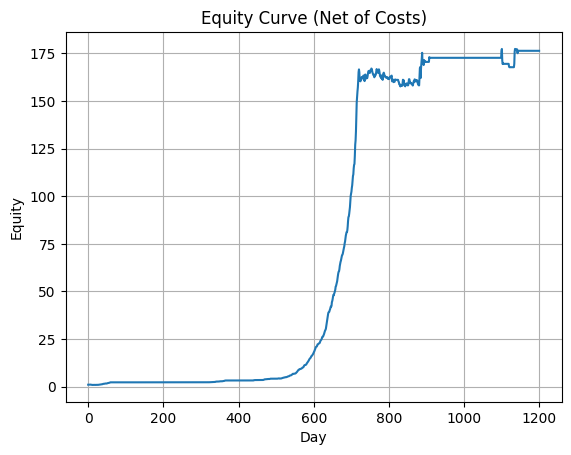

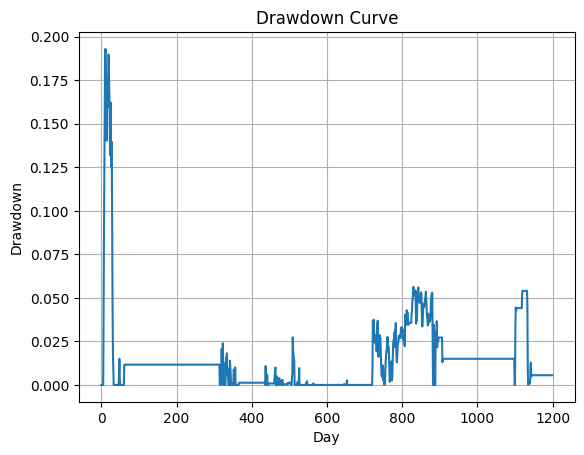

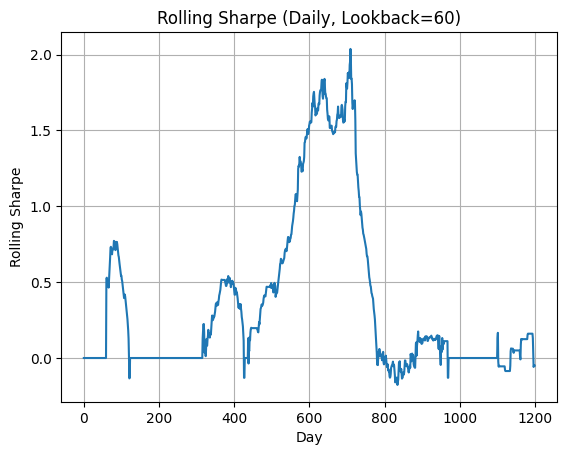

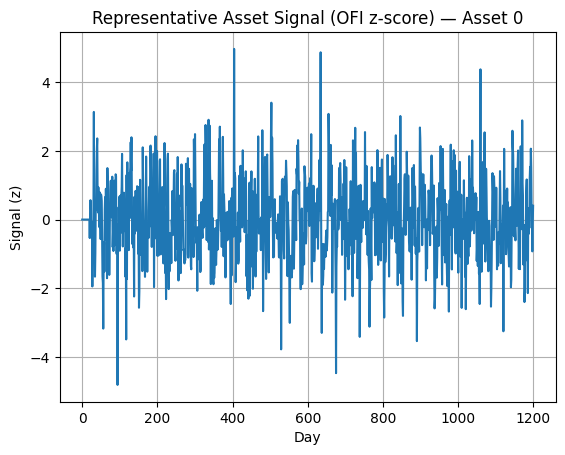

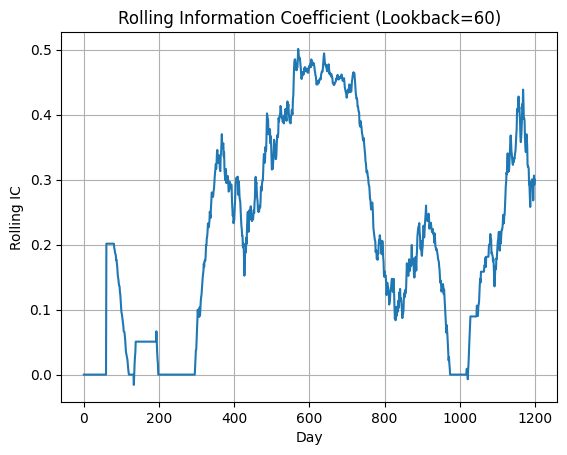

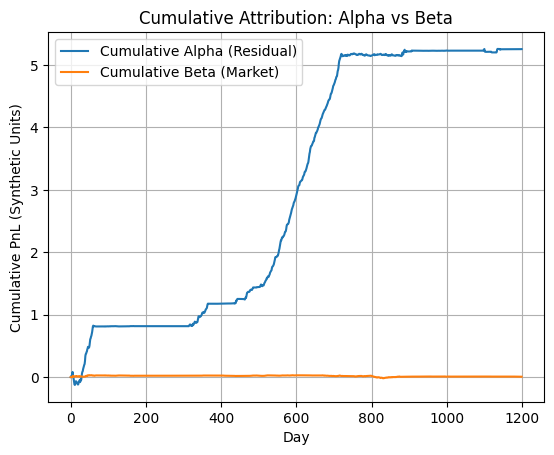

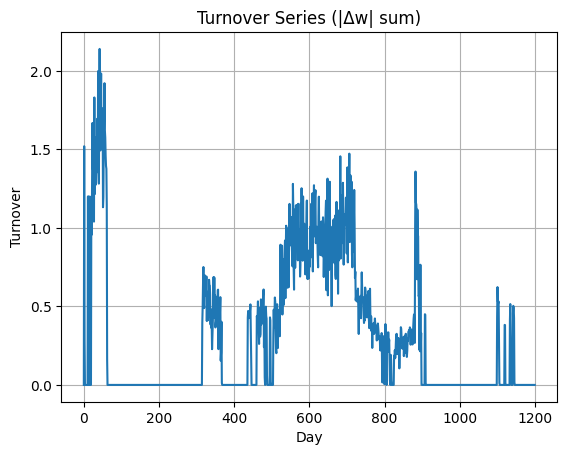

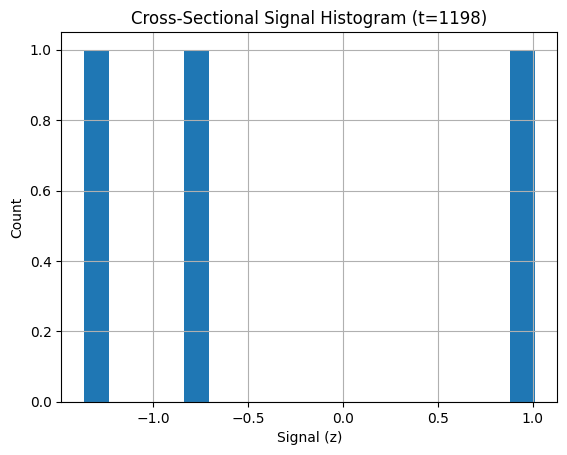

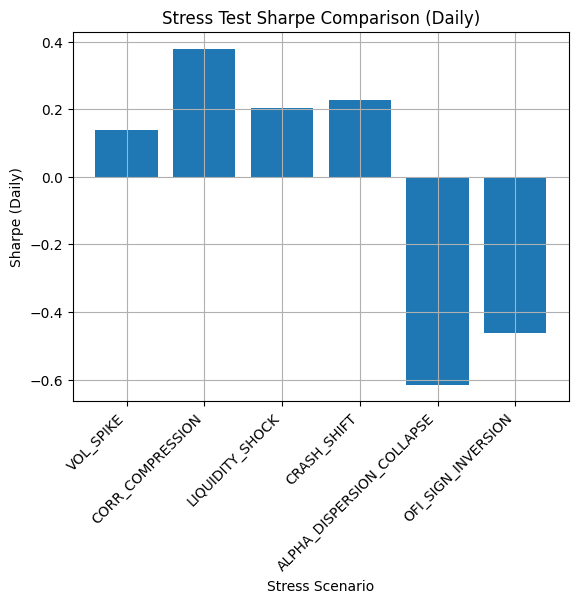

In [12]:
# CELL 9 — Visualization Dashboard (No narrative text; matplotlib only)

diag = json.load(open(os.path.join(DELIV, "diagnostics.json"), "r", encoding="utf-8"))
series = diag["outputs"]["series"]

eq = bt["eq"]
dd = bt["dd"]
rollS = series["rolling_sharpe"]
rollIC = series["rolling_ic"]
turn = bt["turnover"]
cum_alpha = series["cum_alpha"]
cum_beta = series["cum_beta"]

# Choose a representative asset for signal time-series (highest average tradable depth)
avg_depth = []
for i in range(CONFIG["n_assets"]):
    avg_depth.append(mean([market["depth"][t][i] for t in range(CONFIG["n_days"])]))
rep_i = max(range(CONFIG["n_assets"]), key=lambda i: avg_depth[i])

sig_rep = [signal[t][rep_i] for t in range(CONFIG["n_days"])]

# Cross-sectional signal histogram at a late time slice
t_hist = CONFIG["n_days"] - 2
xs_hist = [signal[t_hist][i] for i in range(CONFIG["n_assets"]) if tradable[t_hist][i]]

# Stress Sharpe comparison
stress = json.load(open(os.path.join(DELIV, "stress_test_results.json"), "r", encoding="utf-8"))
stress_rows = stress["outputs"]["stress_results"]
stress_labels = [r["stress"] for r in stress_rows]
stress_sharpes = [r["summary"]["sharpe_daily"] for r in stress_rows]

plt.figure()
plt.plot(eq)
plt.title("Equity Curve (Net of Costs)")
plt.xlabel("Day")
plt.ylabel("Equity")
plt.grid(True)

plt.figure()
plt.plot(dd)
plt.title("Drawdown Curve")
plt.xlabel("Day")
plt.ylabel("Drawdown")
plt.grid(True)

plt.figure()
plt.plot(rollS)
plt.title("Rolling Sharpe (Daily, Lookback=%d)" % CONFIG["vol_lookback"])
plt.xlabel("Day")
plt.ylabel("Rolling Sharpe")
plt.grid(True)

plt.figure()
plt.plot(sig_rep)
plt.title("Representative Asset Signal (OFI z-score) — Asset %d" % rep_i)
plt.xlabel("Day")
plt.ylabel("Signal (z)")
plt.grid(True)

plt.figure()
plt.plot(rollIC)
plt.title("Rolling Information Coefficient (Lookback=%d)" % CONFIG["ic_lookback"])
plt.xlabel("Day")
plt.ylabel("Rolling IC")
plt.grid(True)

plt.figure()
plt.plot(cum_alpha, label="Cumulative Alpha (Residual)")
plt.plot(cum_beta, label="Cumulative Beta (Market)")
plt.title("Cumulative Attribution: Alpha vs Beta")
plt.xlabel("Day")
plt.ylabel("Cumulative PnL (Synthetic Units)")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(turn)
plt.title("Turnover Series (|Δw| sum)")
plt.xlabel("Day")
plt.ylabel("Turnover")
plt.grid(True)

plt.figure()
plt.hist(xs_hist, bins=18)
plt.title("Cross-Sectional Signal Histogram (t=%d)" % t_hist)
plt.xlabel("Signal (z)")
plt.ylabel("Count")
plt.grid(True)

plt.figure()
plt.bar(list(range(len(stress_labels))), stress_sharpes)
plt.title("Stress Test Sharpe Comparison (Daily)")
plt.xlabel("Stress Scenario")
plt.ylabel("Sharpe (Daily)")
plt.xticks(list(range(len(stress_labels))), stress_labels, rotation=45, ha="right")
plt.grid(True)

plt.show()


##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10 — Audit Bundle (Sensitivity, Monte Carlo, Telemetry, Integrity Hashing, and Reproducible Packaging)**

Cell 10 completes the institutional research loop by producing the maximum audit bundle: parameter sensitivity results, Monte Carlo robustness envelope, operational telemetry, artifact hashing, an audit index, and a final zipped archive. The purpose of this cell is governance completeness. In a mechanism-first laboratory, the educational value is only as durable as the reproducibility and defensibility of the artifacts. Cell 10 ensures that every run leaves a complete evidence trail suitable for internal review and replication.

The parameter sensitivity grid is a structured mapping from hyperparameters to outcome summaries. In this OFI lab, the grid varies the signal lookback and participation rate. Those are not arbitrary knobs; they correspond to two core surfaces in order flow trading. Lookback determines signal responsiveness versus noise: shorter lookbacks react faster to imbalance, potentially increasing turnover; longer lookbacks smooth the signal, potentially delaying response. Participation rate determines execution feasibility and impact exposure: higher participation pursues the target portfolio more aggressively, which can push the policy into more nonlinear impact regions. The grid therefore maps how the OFI mechanism and the execution surface interact. The learning objective is to treat sensitivity as a diagnostic of structural dependence, not as an optimization playground.

The Monte Carlo robustness envelope complements sensitivity by turning a single realized PnL path into a distribution of terminal outcomes and drawdowns via resampling. Within the constraints of a synthetic notebook, this provides a disciplined way to discuss dispersion of outcomes and tail behavior. For microstructure strategies, tail behavior is often where execution and regime dependencies manifest, so drawdown distributions are as important as terminal equity distributions. The envelope encourages a professional stance: outcomes should be described as ranges and fragility should be quantified.

Telemetry is implemented as operational provenance rather than performance benchmarking. It records UTC timestamps and durations for each major stage and captures artifact sizes. In a governed research process, telemetry serves as a control: it helps confirm that each stage executed, that artifacts were produced, and that a run can be traced and compared across environments. Because wall-clock times vary by runtime conditions, telemetry is explicitly framed as observational. Its purpose is auditability, not speed claims.

The integrity layer hashes every artifact and stores a master bundle hash. This is the technical foundation of tamper evidence. If any artifact is modified, its hash changes, and the master hash changes. The audit index then serves as a navigational document: it lists required root files and deliverables, embeds telemetry, and records the master hash. The final zip bundle packages all files into a single archive suitable for distribution and replication.

A final feature of Cell 10 in this notebook is execution status reporting. The cell prints a deterministic status panel at the end, listing whether each required artifact exists, its size, and basic sanity checks (grid size, Monte Carlo simulation count, hash presence). This is a practical control that prevents silent failures in interactive environments. For a PhD-level practitioner, the didactic lesson is that research infrastructure must be self-verifying: if a run fails, it should fail loudly and record the failure in the risk log.

The learning objective of Cell 10 is therefore governance literacy. In an order flow mechanism study, the core scientific question is structural—how OFI interacts with liquidity and execution. But in professional practice, the equally important question is procedural: can the experiment be reproduced, reviewed, stress-tested, and audited without ambiguity? Cell 10 answers that question by producing an evi


###10.2.CODE AND IMPLEMENTATION

In [16]:
# CELL 10 — Maximum Audit Bundle (Sensitivity Grid, Monte Carlo Envelope, PRODUCTION TELEMETRY, Hash Registry, Audit Index, ZIP)
# - Deterministic analytics (seeded)
# - Wall-clock telemetry (UTC) + artifact sizes
# - Hard-stop status printing even on failure (try/except/finally)
# - Telemetry embedded in audit_index.json + anchored in run_manifest.json

# ===== CELL 10 START MARKER =====
print("\n\n================ CELL 10 START ================\n")
print("UTC start:", datetime.datetime.now(datetime.timezone.utc).isoformat())

def utc_now():
    return datetime.datetime.now(datetime.timezone.utc)

def safe_getsize(path):
    try:
        return int(os.path.getsize(path))
    except Exception:
        return -1

def fmt_bytes(n):
    if n is None or n < 0:
        return "?"
    units = ["B", "KB", "MB", "GB"]
    f = float(n); u = 0
    while f >= 1024.0 and u < len(units)-1:
        f /= 1024.0; u += 1
    return f"{f:.2f} {units[u]}"

def read_json_safe(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None

def telemetry_stage(tele, name, t0, t1, extra=None):
    rec = {
        "stage": name,
        "start_utc": t0.isoformat(),
        "end_utc": t1.isoformat(),
        "duration_seconds": (t1 - t0).total_seconds()
    }
    if isinstance(extra, dict):
        rec.update(extra)
    tele["outputs"]["stages"].append(rec)

def run_full_pipeline_with_overrides(config, market_overrides=None, lookback_override=None, participation_override=None):
    cfg = dict(config)
    if lookback_override is not None:
        cfg["signal_lookback"] = int(lookback_override)
    if participation_override is not None:
        cfg["participation_rate"] = float(participation_override)

    # Deterministic reset
    random.seed(cfg["seed"])
    mk = generate_market(cfg, REGIMES, shock_overrides=market_overrides)
    sig_m, trad_m = compute_signal_and_tradability_for_market(cfg, mk)
    bt_m = run_backtest(cfg, mk, sig_m, trad_m)
    return cfg, mk, sig_m, trad_m, bt_m

# Paths
audit_index_path = os.path.join(DELIV, "audit_index.json")
hash_reg_path = os.path.join(DELIV, "artifact_hash_registry.json")
param_path = os.path.join(DELIV, "parameter_sensitivity.json")
mc_path = os.path.join(DELIV, "monte_carlo_envelope.json")
review_path = os.path.join(DELIV, "review_checklist.json")
zip_path = os.path.join(ROOT, "lab_bundle.zip")
manifest_path = os.path.join(ROOT, "run_manifest.json")
risk_log_path = os.path.join(ROOT, "risk_log.json")

# TELEMETRY (real & persisted)
telemetry = governed_payload(
    facts={"timestamp_utc": now_utc_iso()},
    assumptions={
        "telemetry": "Wall-clock telemetry via UTC timestamps; times vary by runtime; used for governance ops and run provenance",
        "determinism": "Analytics deterministic for fixed seed/config; telemetry (time) is observational"
    },
    open_items=[
        "If high-resolution profiling is required, allow `time.perf_counter` (not permitted here)",
        "If repeated-run distributions are required, add multiple runs and aggregate"
    ],
    analysis={
        "config_hash": stable_hash_dict(CONFIG),
        "env_fingerprint": {
            "python": sys.version,
            "platform": platform.platform(),
            "executable": sys.executable
        }
    },
    outputs={
        "stages": [],
        "artifact_sizes_bytes": {},
        "bundle_sizes_bytes": {},
        "counts": {},
        "health": {}
    }
)

# Hard-stop wrapper: guarantees status output even on failure
_cell10_failed = False
_cell10_error = {"type": None, "message": None}

try:
    # -----------------------------
    # 1) Parameter Sensitivity Grid
    # -----------------------------
    t0 = utc_now()

    lookbacks = [10, 20, 40]
    parts = [0.06, 0.12, 0.20]

    grid = []
    grid_point_tele = []

    for L in lookbacks:
        for pr in parts:
            pt0 = utc_now()
            cfg_g, mk_g, sig_g, trad_g, bt_g = run_full_pipeline_with_overrides(
                CONFIG, market_overrides=None, lookback_override=L, participation_override=pr
            )
            pt1 = utc_now()
            summ = summarize_run(bt_g)

            grid.append({
                "signal_lookback": L,
                "participation_rate": pr,
                "summary": summ
            })
            grid_point_tele.append({
                "signal_lookback": L,
                "participation_rate": pr,
                "duration_seconds": (pt1 - pt0).total_seconds(),
                "final_equity": summ["final_equity"],
                "sharpe_daily": summ["sharpe_daily"],
                "max_drawdown": summ["max_drawdown"]
            })

    param_payload = governed_payload(
        facts={"timestamp_utc": now_utc_iso()},
        assumptions={"grid": "Vary signal lookback and participation; full rerun each grid point"},
        open_items=[
            "Expand grid to include impact parameters if governance permits deeper exploration",
            "Consider nested stress-on-grid if looking for interaction fragility"
        ],
        analysis={"grid_size": len(grid), "grid_dimensions": {"lookbacks": lookbacks, "participation_rates": parts}},
        outputs={"grid": grid}
    )
    write_json(param_path, param_payload)

    t1 = utc_now()
    telemetry_stage(
        telemetry,
        "parameter_sensitivity_grid",
        t0, t1,
        extra={"grid_size": len(grid), "grid_point_telemetry": grid_point_tele}
    )

    # -----------------------------
    # 2) Monte Carlo Robustness Envelope (>=200)
    # -----------------------------
    t2 = utc_now()

    MC_N = 240
    pnl_base = bt["pnl"][1:]  # drop placeholder
    T = len(pnl_base)
    eq0 = 1.0

    terminal = []
    worst_dd = []

    for k in range(MC_N):
        random.seed(CONFIG["seed"] + 10000 + k)
        eq_mc = eq0
        eq_path = [eq0]
        for _ in range(T):
            r = pnl_base[random.randrange(0, T)]
            eq_mc *= (1.0 + r)
            eq_path.append(eq_mc)
        terminal.append(eq_mc)
        worst_dd.append(max_drawdown(eq_path))

    terminal_sorted = sorted(terminal)
    dd_sorted = sorted(worst_dd)

    def pct(xs, p):
        if not xs:
            return 0.0
        i = int(round((len(xs) - 1) * p))
        i = int(clamp(i, 0, len(xs) - 1))
        return xs[i]

    mc_payload = governed_payload(
        facts={"timestamp_utc": now_utc_iso()},
        assumptions={
            "monte_carlo": "Bootstrap resampling of strategy net pnl; synthetic robustness proxy; not a real-world guarantee",
            "distribution": "Stationary resampling; does not impose block dependence beyond pnl empirical distribution"
        },
        open_items=[
            "Consider block bootstrap for stronger serial dependence (still synthetic)",
            "Consider regime-conditioned bootstrap (still synthetic)"
        ],
        analysis={
            "n_sims": MC_N,
            "path_length": T,
            "terminal_mean": mean(terminal),
            "terminal_stdev": stdev(terminal),
            "terminal_p05": pct(terminal_sorted, 0.05),
            "terminal_p50": pct(terminal_sorted, 0.50),
            "terminal_p95": pct(terminal_sorted, 0.95),
            "dd_mean": mean(worst_dd),
            "dd_p95": pct(dd_sorted, 0.95)
        },
        outputs={
            "terminal_equity_samples": terminal[:],
            "drawdown_samples": worst_dd[:]
        }
    )
    write_json(mc_path, mc_payload)

    t3 = utc_now()
    telemetry_stage(
        telemetry,
        "monte_carlo_envelope",
        t2, t3,
        extra={
            "n_sims": MC_N,
            "terminal_p05": mc_payload["analysis"]["terminal_p05"],
            "terminal_p50": mc_payload["analysis"]["terminal_p50"],
            "terminal_p95": mc_payload["analysis"]["terminal_p95"],
            "dd_p95": mc_payload["analysis"]["dd_p95"]
        }
    )

    # -----------------------------
    # 3) Review Checklist (ensures present in bundle)
    # -----------------------------
    t4 = utc_now()

    checklist = governed_payload(
        facts={"timestamp_utc": now_utc_iso()},
        assumptions={"checklist": "Minimum review gates for synthetic strategy lab"},
        open_items=["Assign named reviewers and external sign-off workflow"],
        analysis={"policy": "All items must be reviewed by humans; outputs remain Not verified"},
        outputs={
            "review_checklist": [
                {"item": "Confirm deterministic seed + config hash", "status": "Not verified"},
                {"item": "Inspect synthetic market assumptions for reasonableness", "status": "Not verified"},
                {"item": "Validate execution cost model sensitivity", "status": "Not verified"},
                {"item": "Review stress suite coverage and conclusions", "status": "Not verified"},
                {"item": "Review fragility tier mapping thresholds", "status": "Not verified"},
                {"item": "Confirm artifact hashing + bundle integrity", "status": "Not verified"},
                {"item": "Independent replication on a clean runtime", "status": "Not verified"},
                {"item": "Model risk committee classification + usage policy", "status": "Not verified"}
            ]
        }
    )
    write_json(review_path, checklist)

    t5 = utc_now()
    telemetry_stage(telemetry, "review_checklist_write", t4, t5, extra={"items": 8})

    # -----------------------------
    # 4) Artifact hashing (tamper-evident)
    # -----------------------------
    t6 = utc_now()

    artifact_paths = []
    # root files
    for fn in ROOT_FILES:
        p = os.path.join(ROOT, fn)
        if os.path.exists(p):
            artifact_paths.append(p)

    # deliverables
    for fn in DELIV_FILES:
        p = os.path.join(DELIV, fn)
        if os.path.exists(p):
            artifact_paths.append(p)

    hash_registry = {}
    for p in artifact_paths:
        rel = os.path.relpath(p, ROOT)
        hash_registry[rel] = sha256_file(p)
        telemetry["outputs"]["artifact_sizes_bytes"][rel] = safe_getsize(p)

    master_bundle_hash = stable_hash_dict(hash_registry)

    hash_payload = governed_payload(
        facts={"timestamp_utc": now_utc_iso()},
        assumptions={"hashing": "SHA-256 per artifact; master hash over registry (sorted, stable JSON)"},
        open_items=["For legal defensibility, store hash registry in external WORM/immutable storage (out of scope)"],
        analysis={"master_bundle_hash": master_bundle_hash, "artifact_count": len(hash_registry)},
        outputs={"artifact_hashes": hash_registry}
    )
    write_json(hash_reg_path, hash_payload)

    t7 = utc_now()
    telemetry_stage(
        telemetry,
        "artifact_hash_registry",
        t6, t7,
        extra={"artifact_count": len(hash_registry), "master_bundle_hash": master_bundle_hash}
    )

    # -----------------------------
    # 5) Zip bundle
    # -----------------------------
    t8 = utc_now()

    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
        for p in artifact_paths:
            arc = os.path.relpath(p, ROOT)
            z.write(p, arcname=arc)

    zip_size = safe_getsize(zip_path)
    telemetry["outputs"]["bundle_sizes_bytes"]["lab_bundle.zip"] = zip_size

    t9 = utc_now()
    telemetry_stage(
        telemetry,
        "zip_bundle",
        t8, t9,
        extra={"zip_path": "lab_bundle.zip", "zip_size_bytes": zip_size}
    )

    # -----------------------------
    # 6) Audit Index (embed telemetry; committee navigation)
    # -----------------------------
    t10 = utc_now()

    telemetry["outputs"]["counts"] = {
        "artifact_count": len(hash_registry),
        "deliverables_expected": len(DELIV_FILES),
        "root_files_expected": len(ROOT_FILES),
        "grid_points": len(grid),
        "mc_sims": MC_N
    }

    telemetry["outputs"]["health"] = {
        "grid_size_ok": (len(grid) == 9),
        "mc_sims_ok": (MC_N >= 200),
        "zip_exists": os.path.exists(zip_path),
        "hash_registry_exists": os.path.exists(hash_reg_path),
        "audit_index_exists": os.path.exists(audit_index_path)  # will become true after write
    }

    audit_index = governed_payload(
        facts={"timestamp_utc": now_utc_iso()},
        assumptions={
            "audit_index": "Primary index for bundle navigation; telemetry embedded; paths relative to notebook working dir"
        },
        open_items=[
            "Attach committee minutes + sign-offs externally if used beyond research",
            "Archive bundle with immutable retention policy if used in regulated workflows"
        ],
        analysis={
            "bundle_master_hash": master_bundle_hash,
            "telemetry_stage_count": len(telemetry["outputs"]["stages"]),
            "telemetry_total_seconds": sum(s.get("duration_seconds", 0.0) for s in telemetry["outputs"]["stages"])
        },
        outputs={
            "root_files": ROOT_FILES,
            "deliverables": DELIV_FILES,
            "master_bundle_hash": master_bundle_hash,
            "telemetry": telemetry
        }
    )
    write_json(audit_index_path, audit_index)

    t11 = utc_now()
    telemetry_stage(
        telemetry,
        "audit_index_write",
        t10, t11,
        extra={"audit_index_bytes": safe_getsize(audit_index_path)}
    )

    # -----------------------------
    # 7) Update manifest with anchors (bundle + telemetry)
    # -----------------------------
    t12 = utc_now()

    rm = read_json_safe(manifest_path)
    if rm is None:
        rm = governed_payload()
        rm["analysis"] = {}
        rm["outputs"] = {}

    rm.setdefault("outputs", {})
    rm["outputs"]["lab_bundle"] = {
        "path": "lab_bundle.zip",
        "master_bundle_hash": master_bundle_hash,
        "zip_size_bytes": zip_size,
        "timestamp_utc": now_utc_iso()
    }
    rm["outputs"]["telemetry_anchor"] = {
        "audit_index_path": "deliverables/audit_index.json",
        "telemetry_stage_count": len(telemetry["outputs"]["stages"]),
        "telemetry_total_seconds": sum(s.get("duration_seconds", 0.0) for s in telemetry["outputs"]["stages"]),
        "timestamp_utc": now_utc_iso()
    }
    write_json(manifest_path, rm)

    t13 = utc_now()
    telemetry_stage(
        telemetry,
        "manifest_update",
        t12, t13,
        extra={"manifest_bytes": safe_getsize(manifest_path)}
    )

except Exception as e:
    _cell10_failed = True
    _cell10_error["type"] = type(e).__name__
    _cell10_error["message"] = str(e)

    print("\n!!! CELL 10 FAILED !!!")
    print("UTC fail:", datetime.datetime.now(datetime.timezone.utc).isoformat())
    print("Error type:", _cell10_error["type"])
    print("Error message:", _cell10_error["message"])

    # Record failure into risk_log.json (best-effort)
    try:
        rl = read_json_safe(risk_log_path)
        if rl is None:
            rl = governed_payload(facts={"timestamp_utc": now_utc_iso()})
        rl.setdefault("analysis", {})
        rl["analysis"]["cell_10_failure"] = {
            "timestamp_utc": now_utc_iso(),
            "error_type": _cell10_error["type"],
            "error_message": _cell10_error["message"]
        }
        write_json(risk_log_path, rl)
        print("Failure recorded in risk_log.json")
    except Exception as e2:
        print("Could not write risk_log.json failure record:", str(e2))

finally:
    # -----------------------------
    # ALWAYS PRINT STATUS (even if failure)
    # -----------------------------
    paths = {
        "deliverables/parameter_sensitivity.json": param_path,
        "deliverables/monte_carlo_envelope.json": mc_path,
        "deliverables/review_checklist.json": review_path,
        "deliverables/artifact_hash_registry.json": hash_reg_path,
        "deliverables/audit_index.json": audit_index_path,
        "run_manifest.json": manifest_path,
        "lab_bundle.zip": zip_path,
        "risk_log.json": risk_log_path
    }

    print("\n---------------- CELL 10 STATUS ----------------")
    print("UTC end:", datetime.datetime.now(datetime.timezone.utc).isoformat())
    print("Cell10 failed?:", _cell10_failed)
    if _cell10_failed:
        print("Failure type:", _cell10_error["type"])
        print("Failure msg :", _cell10_error["message"])

    for k, p in paths.items():
        ok = os.path.exists(p)
        print(f"{k:44s}  {'OK' if ok else 'MISSING':7s}  size={fmt_bytes(safe_getsize(p))}")

    # Sanity reads
    pm = read_json_safe(param_path)
    mc = read_json_safe(mc_path)
    hr = read_json_safe(hash_reg_path)
    ai = read_json_safe(audit_index_path)
    mf = read_json_safe(manifest_path)

    grid_size = None
    if pm:
        grid_size = len(pm.get("outputs", {}).get("grid", []))

    mc_n = None
    if mc:
        mc_n = mc.get("analysis", {}).get("n_sims", None)

    master_hash = None
    if hr:
        master_hash = hr.get("analysis", {}).get("master_bundle_hash", None)

    print("\n-- Sanity Checks --")
    print("Grid size (expected 9):", grid_size)
    print("Monte Carlo sims (>=200):", mc_n)
    print("Master bundle hash present:", bool(master_hash))

    # Telemetry presence (embedded in audit_index.json)
    tele = None
    if ai:
        tele = ai.get("outputs", {}).get("telemetry", None)

    print("\n-- Telemetry --")
    if isinstance(tele, dict):
        stages = tele.get("outputs", {}).get("stages", []) or []
        total_secs = 0.0
        for s in stages:
            try:
                total_secs += float(s.get("duration_seconds", 0.0))
            except Exception:
                pass
        print("Telemetry stages:", len(stages))
        print("Telemetry total seconds:", round(total_secs, 6))
        tail = stages[-8:] if len(stages) > 8 else stages
        for s in tail:
            print("  -", s.get("stage"), "| secs:", s.get("duration_seconds"),
                  "| start:", s.get("start_utc"), "| end:", s.get("end_utc"))
    else:
        print("Telemetry: MISSING (audit_index.json not written or telemetry not embedded)")

    # Manifest anchor check
    print("\n-- Manifest Anchor --")
    tele_anchor = None
    if mf:
        tele_anchor = mf.get("outputs", {}).get("telemetry_anchor", None)
    if isinstance(tele_anchor, dict):
        print("telemetry_anchor.stage_count :", tele_anchor.get("telemetry_stage_count"))
        print("telemetry_anchor.total_seconds:", tele_anchor.get("telemetry_total_seconds"))
        print("telemetry_anchor.audit_index_path:", tele_anchor.get("audit_index_path"))
    else:
        print("telemetry_anchor: MISSING")

    print("\n================ CELL 10 END ================\n")




================ CELL 10 START ================

UTC start: 2026-02-12T20:26:48.119233+00:00

---------------- CELL 10 STATUS ----------------
UTC end: 2026-02-12T20:27:48.348931+00:00
Cell10 failed?: False
deliverables/parameter_sensitivity.json       OK       size=4.02 KB
deliverables/monte_carlo_envelope.json        OK       size=13.28 KB
deliverables/review_checklist.json            OK       size=1.34 KB
deliverables/artifact_hash_registry.json      OK       size=2.68 KB
deliverables/audit_index.json                 OK       size=8.35 KB
run_manifest.json                             OK       size=1.90 KB
lab_bundle.zip                                OK       size=373.69 KB
risk_log.json                                 OK       size=771.00 B

-- Sanity Checks --
Grid size (expected 9): 9
Monte Carlo sims (>=200): 240
Master bundle hash present: True

-- Telemetry --
Telemetry stages: 5
Telemetry total seconds: 60.224947
  - parameter_sensitivity_grid | secs: 59.876816 | start: 202

##11.CONCLUSION

**B. Conclusion — Strategy 8: Order Flow Mechanism (What Was Learned, What Breaks, How to Iterate)**

This laboratory is a reminder that in microstructure, theory is cheap and execution is expensive. The notebook’s central contribution is not a single metric, but a structured way to see the relationship between **order flow pressure** and **liquidity constraints** as a mechanism that lives or dies by feasibility. When OFI is interpreted as a state variable—an observable summary of aggressive demand versus supply—it becomes clear why order flow strategies cannot be evaluated in the same mental frame as slow-moving factor models. Here, the time horizon is short, turnover is structural, and costs scale nonlinearly. The “strategy” is therefore inseparable from its execution environment. A backtest that ignores depth and spreads is not incomplete; it is conceptually mis-specified.

The first structural insight is that OFI is only meaningful when paired with a microeconomic story of who absorbs it. In calm regimes with ample depth and narrow spreads, liquidity providers can warehouse inventory cheaply, and the marginal price effect of imbalance is smaller. In crisis regimes, the same imbalance interacts with thin depth, widening spreads, and higher volatility, which raises the inventory risk of liquidity providers. The notebook makes this concrete by changing depth and spreads across regimes and by embedding a convex impact function. In other words, the lab demonstrates that OFI is not a “signal” floating above the market; it is a perturbation applied to a constrained system. When constraints tighten, the perturbation has larger consequences. That is mechanism-first thinking in its simplest form.

The second insight concerns surfaces. The notebook implicitly constructs an **execution surface**: a mapping from desired turnover to realized costs given depth, spreads, and participation. This surface is where many microstructure ideas fail. A signal can be directionally correct in a frictionless sense yet be untradeable once the policy is constrained. The participation limiter ensures that the agent can only move toward target weights gradually when depth is scarce, which captures a professional reality: the portfolio you want is not the portfolio you can have. Under stress, this gap widens, and the agent accumulates execution debt. That is not merely a performance drag; it is a fragility channel because delayed execution can turn the strategy into an unintended exposure.

A third insight is that neutrality is not immunity. The policy is constructed to be approximately dollar-neutral, and the notebook estimates beta to a synthetic market factor to decompose realized returns into beta-attributed and residual components. This highlights a common professional trap: a microstructure strategy can appear to be “alpha” when it is actually harvesting liquidity premia that correlate with market regimes or volatility states. Beta itself can become unstable across regimes, which turns attribution into a moving target. The notebook’s stress suite and diagnostics make this instability visible, not by claiming it is “true,” but by showing how easily it can occur in a controlled system.

Fragility modes are the core lesson. This lab attacks the OFI hypothesis directly with strategy-specific stresses: collapse the OFI predictive channel, or invert its sign. These stresses are not generic volatility spikes; they are hypothesis tests. They teach a research discipline: do not only stress the environment; stress the mechanism. If the strategy’s performance depends on a stable OFI-to-return mapping, then the natural fragility is that this mapping erodes—through competition, adverse selection, regime change, or microstructural design changes. In the synthetic lab, that erosion is implemented explicitly, and the resulting degradation is summarized through a fragility score that combines Sharpe degradation and drawdown amplification. The point is not the number; the point is the structure: a coherent way to translate “what breaks” into auditable diagnostics.

Execution dominates theory in another way: turnover is not merely a nuisance, it is a state variable. The notebook monitors turnover and cost aggregation, and it shows how changes in participation or depth reshape the realized strategy. In microstructure, capacity cliffs can appear suddenly. A small increase in trading intensity can push the policy into a nonlinear region of the impact surface, where costs accelerate and the strategy’s effective exposure becomes unstable. The parameter sensitivity grid is therefore not a convenience; it is an institutional requirement. It demonstrates how sensitive outcomes are to lookback choice (which shapes signal noise and responsiveness) and participation rate (which shapes feasibility). Mechanism-first experimentation is the art of mapping these sensitivities, not optimizing a single backtest run.

The Monte Carlo robustness envelope provides a complementary perspective. By resampling realized net PnL paths, the notebook constructs a distribution of terminal equity outcomes and drawdowns. In a real research stack, one might prefer block bootstrap or regime-conditioned resampling, but within the constraints of this lab, the envelope still performs an important function: it shifts attention from point outcomes to distributions, and it makes drawdown risk explicit. For microstructure strategies, tail behavior is frequently dominated by liquidity and execution effects, which are precisely the channels stressed elsewhere in the notebook. The Monte Carlo layer reinforces the same professional intuition: a strategy is not “good” because it wins on average; it is acceptable only if its loss modes are understood, bounded, and governed.

How should a researcher iterate? The correct iteration is causal, not opportunistic. Start with the mechanism: the OFI process, its persistence, and its mapping to returns conditional on depth. Perturb one axis at a time. Increase correlation compression to reduce cross-sectional diversification and observe whether neutrality remains meaningful. Reduce depth to test capacity. Widen spreads to stress the immediacy premium. Then stress the hypothesis directly: damp the OFI coefficient, invert it, or make it time-varying to mimic structural breaks. Next, modify execution primitives: increase impact convexity, tighten participation, or impose stricter tradability filters. Each perturbation should produce a predictable change in diagnostics if the researcher understands the mechanism. When it does not, the gap is the learning target.

The governance layer completes the professional cycle. This notebook does not pretend to be a production trading system; it is a controlled laboratory. Yet it produces a regulator-ready audit bundle precisely because educational research becomes valuable only when it is reproducible and reviewable. The artifacts are not decorative. They encode assumptions, open items, diagnostic series, stress results, sensitivity maps, and integrity hashes. They provide the scaffold for committee review and for the humility required in quantitative research: everything here is “Not verified” until independently replicated and validated. In that sense, the conclusion is methodological: the strategy is a case study, but the governed research process is the enduring product. For an order flow mechanism, that process must always place execution first, treat regime dependence as structural, and confront fragility directly.

